# Milestone 3 - Database Population/SQL Queries 
**Group 4: William Hendrickson, Brendan Veit, Justin Waldman and Jorge Fioranelli**

In this notebook we will pre-process the data, perform entity resolution, populate the database and run the queries.

## 1 Pre-process the Data

### 1.1 Loading the Data

In this step, we import all the required libraries and load the 3 data files: Traffic_Crashes_-_Crashes.csv, Traffic_Crashes_-_People.csv and Traffic_Crashes_-_Vehicles.csv.

Note: Altough we are loading the files locally, you can download the latest version of these files from https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data

In [ ]:
import pandas as pd
import psycopg2
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import jellyfish
import time
import csv
from datetime import datetime
import io

In [4]:
crashes_df = pd.read_csv('Traffic_Crashes_-_Crashes.csv')
vehicles_df = pd.read_csv('Traffic_Crashes_-_Vehicles.csv')
people_df = pd.read_csv('Traffic_Crashes_-_People.csv')

/var/folders/_h/gkfcf4fs76v1xrbjqj37qs500000gq/T/ipykernel_67433/3176824023.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  crashes_df = pd.read_csv('Traffic_Crashes_-_Crashes.csv')
/var/folders/_h/gkfcf4fs76v1xrbjqj37qs500000gq/T/ipykernel_67433/3176824023.py:2: DtypeWarning: Columns (20,39,40,41,43,47,48,49,52,54,57,58,60,70) have mixed types. Specify dtype option on import or set low_memory=False.
  vehicles_df = pd.read_csv('Traffic_Crashes_-_Vehicles.csv')
/var/folders/_h/gkfcf4fs76v1xrbjqj37qs500000gq/T/ipykernel_67433/3176824023.py:3: DtypeWarning: Columns (19,28) have mixed types. Specify dtype option on import or set low_memory=False.
  people_df = pd.read_csv('Traffic_Crashes_-_People.csv')


Some columns are raising warnings but don't worry, we will cleanup the columns later.

### 1.2 Exploring the Raw Data

In this section we provide the top 5 rows of each of the datasets so we can get an idea of their raw schema. We also provide some basic statistics to understand better the shape of the data.

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Crashes Data

The crashes dataset is the most important one, as it contains the details of each crash. 

In [ ]:
display(crashes_df.head(5))

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,NaN,08/18/2023 12:50:00 PM,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",08/18/2023 12:55:00 PM,FOLLOWING TOO CLOSELY,DISTRACTION - FROM INSIDE VEHICLE,700,W,OHARE ST,1654.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN
1,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,NaN,07/29/2023 02:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,Y,"OVER $1,500",07/29/2023 02:45:00 PM,FAILING TO REDUCE SPEED TO AVOID CRASH,"OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELE...",2101,S,ASHLAND AVE,1235.0,NaN,NaN,NaN,NaN,NaN,NaN,4,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14,7,7,41.854120,-87.665902,POINT (-87.665902342962 41.854120262952)
2,61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9c...,NaN,08/18/2023 05:58:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"$501 - $1,500",08/18/2023 06:01:00 PM,FAILING TO REDUCE SPEED TO AVOID CRASH,UNABLE TO DETERMINE,3422,N,LONG AVE,1633.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NONINCAPACITATING INJURY,1.0,0.0,0.0,1.0,0.0,1.0,0.0,17,6,8,41.942976,-87.761883,POINT (-87.761883496974 41.942975745006)
3,004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab33...,NaN,11/26/2019 08:38:00 AM,25,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PEDESTRIAN,ONE-WAY,NaN,CURVE ON GRADE,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,NaN,NaN,NaN,"OVER $1,500",11/26/2019 08:38:00 AM,UNABLE TO DETERMINE,NOT APPLICABLE,5,W,TERMINAL ST,1655.0,Y,Y,NaN,NaN,NaN,NaN,2,FATAL,1.0,1.0,0.0,0.0,0.0,1.0,0.0,8,3,11,NaN,NaN,NaN
4,a1d5f0ea90897745365a4cbb06cc60329a120d89753fac...,NaN,08/18/2023 10:45:00 AM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,FIXED OBJECT,OTHER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",08/18/2023 10:48:00 AM,FOLLOWING TOO CLOSELY,DRIVING SKILLS/KNOWLEDGE/EXPERIENCE,3,W,TERMINAL ST,1653.0,NaN,NaN,NaN,NaN,NaN,NaN,1,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10,6,8,NaN,NaN,NaN


In its raw form, it contains around 1M rows and 48 columns, with multiple of them containing a large number of missing values (that we will fix later).

In [ ]:
display(crashes_df.info(show_counts=True, verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 934459 entries, 0 to 934458
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                934459 non-null  object 
 1   CRASH_DATE_EST_I               68625 non-null   object 
 2   CRASH_DATE                     934459 non-null  object 
 3   POSTED_SPEED_LIMIT             934459 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         934459 non-null  object 
 5   DEVICE_CONDITION               934459 non-null  object 
 6   WEATHER_CONDITION              934459 non-null  object 
 7   LIGHTING_CONDITION             934459 non-null  object 
 8   FIRST_CRASH_TYPE               934459 non-null  object 
 9   TRAFFICWAY_TYPE                934459 non-null  object 
 10  LANE_CNT                       199023 non-null  float64
 11  ALIGNMENT                      934459 non-null  object 
 12  ROADWAY_SURFACE_COND          

None

And here we can see the size of each column in MB.

In [ ]:
display(crashes_df.memory_usage(deep=True).sort_values(ascending=False) / 1e6)

CRASH_RECORD_ID                  172.874915
LOCATION                          89.989762
CRASH_TYPE                        76.342301
PRIM_CONTRIBUTORY_CAUSE           75.417576
MOST_SEVERE_INJURY                74.599820
DATE_POLICE_NOTIFIED              73.822261
CRASH_DATE                        73.822261
SEC_CONTRIBUTORY_CAUSE            71.438939
ALIGNMENT                         70.035114
REPORT_TYPE                       68.883605
TRAFFICWAY_TYPE                   66.413611
DEVICE_CONDITION                  66.162923
FIRST_CRASH_TYPE                  65.867324
TRAFFIC_CONTROL_DEVICE            64.708541
DAMAGE                            64.124594
LIGHTING_CONDITION                63.402232
STREET_NAME                       63.244009
ROAD_DEFECT                       62.075166
WEATHER_CONDITION                 58.270070
ROADWAY_SURFACE_COND              56.718262
STREET_DIRECTION                  54.198518
HIT_AND_RUN_I                     37.523314
INTERSECTION_RELATED_I          

As part of our exploratory analysis we can see how different values of LIGHTING_CONDITION relate to the MOST_SEVERE_INJURY.

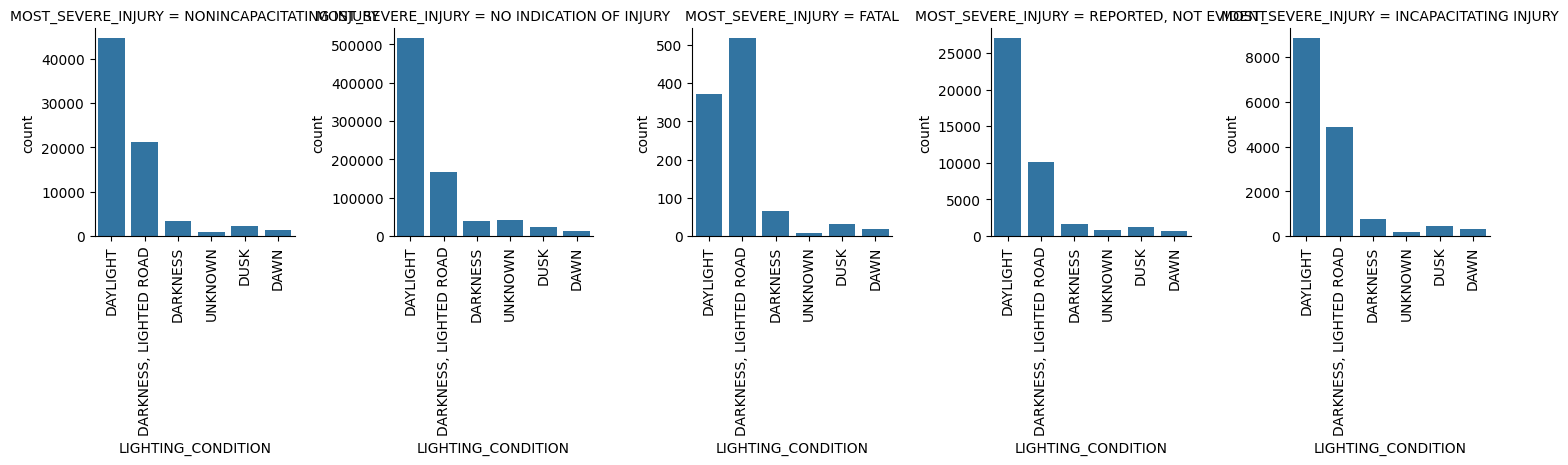

<Figure size 1200x1000 with 0 Axes>

In [ ]:
stacked_df = crashes_df[['LIGHTING_CONDITION', 'MOST_SEVERE_INJURY']]

lighting_condition_order = stacked_df['LIGHTING_CONDITION'].unique()

g = sns.FacetGrid(stacked_df, col='MOST_SEVERE_INJURY', sharey=False)
g.map(sns.countplot, 'LIGHTING_CONDITION', order=lighting_condition_order)
g.set_xticklabels(rotation=90)
plt.figure(figsize=(12, 10))
plt.tight_layout()
plt.show()

### Vehicles Data

Now we will explore our second dataset, the Vehicles associated with the crashes.

In [ ]:
display(vehicles_df.head(5))

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,10,2e31858c0e411f0bdcb337fb7c415aa93763cf2f23e02f...,08/04/2015 12:40:00 PM,1,DRIVER,NaN,10.0,NaN,FORD,Focus,IL,2001.0,NONE,PASSENGER,PERSONAL,N,TURNING LEFT,NaN,NaN,1.0,NaN,NaN,NaN,N,Y,Y,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,e73b35bd7651b0c6693162bee0666db159b28901437009...,07/31/2015 05:50:00 PM,1,DRIVER,NaN,96.0,NaN,NISSAN,Pathfinder,IL,1999.0,NONE,SPORT UTILITY VEHICLE (SUV),PERSONAL,E,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000,f2b1adeb85a15112e4fb7db74bff440d6ca53ff7a21e10...,09/02/2015 11:45:00 AM,1,DRIVER,NaN,954.0,NaN,FORD,F150,KS,NaN,UNKNOWN,VAN/MINI-VAN,UNKNOWN/NA,W,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000,15a3e24fce3ce7cd2b02d44013d1a93ff2fbdca80632ec...,10/31/2015 09:30:00 PM,2,DRIVER,NaN,9561.0,NaN,HYUNDAI,SONATA,NaN,2011.0,NONE,PASSENGER,PERSONAL,E,SLOW/STOP IN TRAFFIC,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100000,1d3c178880366c77deaf06b8c3198429112a1c8e8807ed...,11/16/2016 01:00:00 PM,2,PARKED,NaN,96745.0,NaN,"TOYOTA MOTOR COMPANY, LTD.",RAV4 (sport utility),IL,2001.0,UNKNOWN,SPORT UTILITY VEHICLE (SUV),NOT IN USE,S,PARKED,NaN,NaN,0.0,NaN,NaN,NaN,N,Y,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UNKNOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It contains around 2M rows and 71 columns. As with the previous dataset, multiple columns contain a large number of missing values that we will fix later.

In [ ]:
display(vehicles_df.info(show_counts=True, verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1905852 entries, 0 to 1905851
Data columns (total 71 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   CRASH_UNIT_ID             1905852 non-null  int64  
 1   CRASH_RECORD_ID           1905852 non-null  object 
 2   CRASH_DATE                1905852 non-null  object 
 3   UNIT_NO                   1905852 non-null  int64  
 4   UNIT_TYPE                 1903558 non-null  object 
 5   NUM_PASSENGERS            282001 non-null   float64
 6   VEHICLE_ID                1861321 non-null  float64
 7   CMRC_VEH_I                35439 non-null    object 
 8   MAKE                      1861316 non-null  object 
 9   MODEL                     1861171 non-null  object 
 10  LIC_PLATE_STATE           1691074 non-null  object 
 11  VEHICLE_YEAR              1566758 non-null  float64
 12  VEHICLE_DEFECT            1861321 non-null  object 
 13  VEHICLE_TYPE              1

None

We can see here the size of each column in MB.

In [ ]:
display(vehicles_df.memory_usage(deep=True).sort_values(ascending=False) / 1e6)

CRASH_RECORD_ID             352.582620
CRASH_DATE                  150.562308
MANEUVER                    131.606717
VEHICLE_TYPE                130.171232
MODEL                       125.635146
FIRST_CONTACT_POINT         124.910758
VEHICLE_USE                 124.001800
MAKE                        122.725689
UNIT_TYPE                   120.196153
VEHICLE_DEFECT              117.557413
TRAVEL_DIRECTION            110.358789
LIC_PLATE_STATE             106.646262
AREA_01_I                    74.328540
AREA_11_I                    71.057012
AREA_12_I                    70.745324
AREA_02_I                    68.783234
AREA_06_I                    68.752320
AREA_05_I                    68.328546
AREA_07_I                    68.322384
AREA_08_I                    67.816502
TOWED_BY                     67.384961
TOWED_I                      67.144454
AREA_99_I                    66.642758
AREA_10_I                    66.241760
AREA_03_I                    65.763308
AREA_04_I                

As part of our exploratory analysis, we can see the distribution of the year of the vehicle.

<Axes: xlabel='VEHICLE_YEAR'>

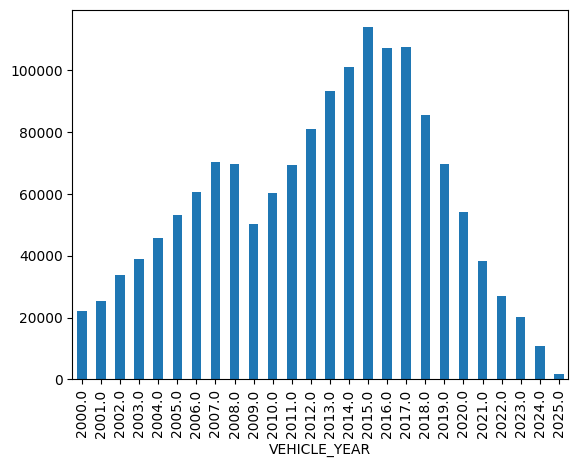

In [ ]:
(vehicles_df[(vehicles_df['VEHICLE_YEAR'] >= 2000) & (vehicles_df['VEHICLE_YEAR'] <= 2025)]
    .groupby(['VEHICLE_YEAR'])
    .size()
    .plot(kind='bar'))

While looking at the raw data, we noticed that the column MAKE contain a lot of misspellings. We will fix this later with entity resolution. Here you can see some examples. 

In [ ]:
print("")
print("Multiple TOYOTA spellings in MAKE:")
print(vehicles_df[vehicles_df['MAKE'].fillna('').str.lower().str.contains('oyot')]['MAKE'].value_counts().sort_index())

print("")
print("Multiple KENWORTH MOTOR TRUCK spellings in MAKE:")
print(vehicles_df[vehicles_df['MAKE'].fillna('').str.startswith('KENWORTH MOTOR TRUCK')]['MAKE'].value_counts().sort_index())


Multiple TOYOTA spellings in MAKE:
MAKE
TOYOTA                        119236
TOYOTA MOTOR COMPANY, LTD.     89215
Name: count, dtype: int64

Multiple KENWORTH MOTOR TRUCK spellings in MAKE:
MAKE
KENWORTH MOTOR TRUCK CO.         912
KENWORTH MOTOR TRUCK COMPANY    1224
Name: count, dtype: int64


### People Data

Finally, our last dataset contains the details of the people involved in the crashes.

In [ ]:
display(people_df.head(5))

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,25.0,IL,D,NONE PRESENT,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,M,37.0,IL,NaN,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,IMPROPER BACKING,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


This dataset contains over 2M rows and 29 columns. Again, many of these columns are sparse and we will clean later.

In [ ]:
display(people_df.info(show_counts=True, verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051683 entries, 0 to 2051682
Data columns (total 29 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   PERSON_ID              2051683 non-null  object 
 1   PERSON_TYPE            2051683 non-null  object 
 2   CRASH_RECORD_ID        2051683 non-null  object 
 3   VEHICLE_ID             2009599 non-null  float64
 4   CRASH_DATE             2051683 non-null  object 
 5   SEAT_NO                414429 non-null   float64
 6   CITY                   1493591 non-null  object 
 7   STATE                  1516384 non-null  object 
 8   ZIPCODE                1375482 non-null  object 
 9   SEX                    2016922 non-null  object 
 10  AGE                    1455040 non-null  float64
 11  DRIVERS_LICENSE_STATE  1201944 non-null  object 
 12  DRIVERS_LICENSE_CLASS  997383 non-null   object 
 13  SAFETY_EQUIPMENT       2045957 non-null  object 
 14  AIRBAG_DEPLOYED   

None

This is the largest of the three datasets in terms of rows, but the smallest one in number of columns. Here you can see its size in MB.

In [ ]:
display(people_df.memory_usage(deep=True).sort_values(ascending=False) / 1e6)

CRASH_RECORD_ID          379.561355
INJURY_CLASSIFICATION    164.020585
CRASH_DATE               162.082957
SAFETY_EQUIPMENT         146.675797
AIRBAG_DEPLOYED          146.202102
BAC_RESULT               132.641702
PERSON_ID                131.943782
PERSON_TYPE              130.635471
EJECTION                 124.897113
DRIVER_VISION            122.124796
DRIVER_ACTION            121.085078
SEX                      118.093828
PHYSICAL_CONDITION       117.098737
CITY                     114.303781
ZIPCODE                  106.924259
STATE                    106.596224
DRIVERS_LICENSE_STATE     98.106344
DRIVERS_LICENSE_CLASS     91.616070
HOSPITAL                  76.892022
EMS_AGENCY                71.773435
PEDPEDAL_VISIBILITY       67.562772
PEDPEDAL_ACTION           67.465286
PEDPEDAL_LOCATION         67.092355
EMS_RUN_NO                66.599832
CELL_PHONE_USE            65.684016
AGE                       16.413464
SEAT_NO                   16.413464
VEHICLE_ID                16

While exploring the people dataset, we noticed that most of the accidents involve people in their mid-twenties.

<Axes: xlabel='AGE'>

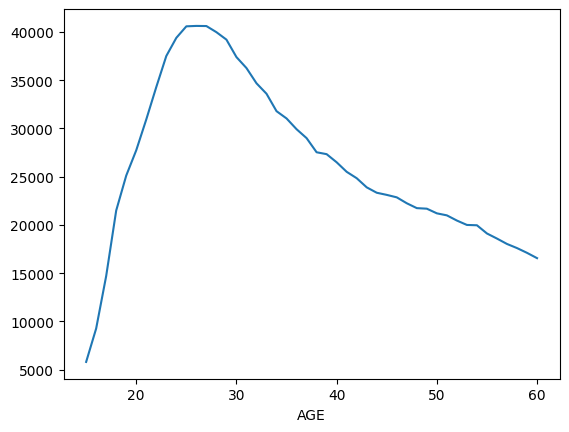

In [ ]:
people_df[(people_df["AGE"] >= 15) & (people_df["AGE"] <= 60)].groupby(["AGE"]).size().plot(kind='line')

We also noticed a lot of misspellings in the CITY column that we will improve with entity resolution next. Here you can see some examples.

In [ ]:
print("")
print("Multiple University Park spellings in CITY:")
print(people_df[people_df['CITY'].fillna('').str.lower().str.startswith('uni') & people_df['CITY'].fillna('').str.lower().str.contains('park')]['CITY'].value_counts().sort_index())

print("")
print("Multiple Chicago spellings in CITY:")
print(people_df[people_df['CITY'].fillna('').str.startswith('C') & people_df['CITY'].fillna('').str.endswith('CAGO')]['CITY'].value_counts().sort_index())



Multiple University Park spellings in CITY:
CITY
UNIERSITY PARK          1
UNITVERSITY PARK        1
UNIVERESITY PARK        1
UNIVERISTIY PARK        1
UNIVERISTY PARK         4
UNIVERSIETY PARK        1
UNIVERSIRT PARK         1
UNIVERSITY PARK       752
UNIVERSITY PARK DR      1
UNIVERSITYB PARK        1
UNIVERSITYPARK          1
UNIVERSIY PARK          1
UNIVESITY PARK          1
UNIVESIY PARK           1
Name: count, dtype: int64

Multiple Chicago spellings in CITY:
CITY
C HICAGO                 8
C ICAGO                  1
C;HICAGO                 1
CAGO                     1
CAHICAGO                 3
CBHICAGO                 2
CBICAGO                  1
CCHICAGO                18
CCICAGO                  1
CDHICAGO                 3
CFHICAGO                 1
CG=HICAGO                1
CGHICAGO                 4
CGICAGO                 34
CH8ICAGO                 1
CH9ICAGO                 1
CH;ICAGO                 1
CHACAGO                  1
CHAICAGO                 4
CHCAG

### 1.3 Dropping Sparse Columns

As discussed before, many columns contain missing values. In this section we are going to delete any column that contains over 30% of missing values.

In [5]:
def sparse_columns(df):
    threshold = 0.3
    missing_ratio = df.isnull().mean()
    return missing_ratio[missing_ratio > threshold].index.tolist()

In [ ]:
crashes_sparse_columns = sparse_columns(crashes_df)
people_sparse_columns = sparse_columns(people_df)
vehicles_sparse_columns = sparse_columns(vehicles_df)

display(crashes_sparse_columns)
display(people_sparse_columns)
display(vehicles_sparse_columns)

crashes_df.drop(columns=crashes_sparse_columns, inplace=True)
people_df.drop(columns=people_sparse_columns, inplace=True)
vehicles_df.drop(columns=vehicles_sparse_columns, inplace=True)

['CRASH_DATE_EST_I',
 'LANE_CNT',
 'INTERSECTION_RELATED_I',
 'NOT_RIGHT_OF_WAY_I',
 'HIT_AND_RUN_I',
 'PHOTOS_TAKEN_I',
 'STATEMENTS_TAKEN_I',
 'DOORING_I',
 'WORK_ZONE_I',
 'WORK_ZONE_TYPE',
 'WORKERS_PRESENT_I']

['SEAT_NO',
 'ZIPCODE',
 'DRIVERS_LICENSE_STATE',
 'DRIVERS_LICENSE_CLASS',
 'HOSPITAL',
 'EMS_AGENCY',
 'EMS_RUN_NO',
 'PEDPEDAL_ACTION',
 'PEDPEDAL_VISIBILITY',
 'PEDPEDAL_LOCATION',
 'BAC_RESULT VALUE',
 'CELL_PHONE_USE']

['NUM_PASSENGERS',
 'CMRC_VEH_I',
 'TOWED_I',
 'FIRE_I',
 'EXCEED_SPEED_LIMIT_I',
 'TOWED_BY',
 'TOWED_TO',
 'AREA_00_I',
 'AREA_01_I',
 'AREA_02_I',
 'AREA_03_I',
 'AREA_04_I',
 'AREA_05_I',
 'AREA_06_I',
 'AREA_07_I',
 'AREA_08_I',
 'AREA_09_I',
 'AREA_10_I',
 'AREA_11_I',
 'AREA_12_I',
 'AREA_99_I',
 'CMV_ID',
 'USDOT_NO',
 'CCMC_NO',
 'ILCC_NO',
 'COMMERCIAL_SRC',
 'GVWR',
 'CARRIER_NAME',
 'CARRIER_STATE',
 'CARRIER_CITY',
 'HAZMAT_PLACARDS_I',
 'HAZMAT_NAME',
 'UN_NO',
 'HAZMAT_PRESENT_I',
 'HAZMAT_REPORT_I',
 'HAZMAT_REPORT_NO',
 'MCS_REPORT_I',
 'MCS_REPORT_NO',
 'HAZMAT_VIO_CAUSE_CRASH_I',
 'MCS_VIO_CAUSE_CRASH_I',
 'IDOT_PERMIT_NO',
 'WIDE_LOAD_I',
 'TRAILER1_WIDTH',
 'TRAILER2_WIDTH',
 'TRAILER1_LENGTH',
 'TRAILER2_LENGTH',
 'TOTAL_VEHICLE_LENGTH',
 'AXLE_CNT',
 'VEHICLE_CONFIG',
 'CARGO_BODY_TYPE',
 'LOAD_TYPE',
 'HAZMAT_OUT_OF_SERVICE_I',
 'MCS_OUT_OF_SERVICE_I',
 'HAZMAT_CLASS']

### 1.4 Remove NAs

Now that we removed columns with sparse data, we can proceed to remove rows with NAs.

In [7]:
crashes_df.dropna(inplace=True)
vehicles_df.dropna(inplace=True)
people_df.dropna(inplace=True)

### 1.5 Renaming Columns

There is a misleading column name called "VEHICLE_ID" in vehicles_df since the actual identifier is the column "CRASH_UNIT_ID".

The dataset has no description for this column, but interesting enough the people_df dataset has also a column called "VEHICLE_ID" that corresponds to "CRASH_UNIT_ID".

> VEHICLE_ID: The corresponding CRASH_UNIT_ID from the Vehicles dataset.

Source: https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data

To avoid any confusion, we are dropping VEHICLE_ID and renaming CRASH_UNIT_ID to VEHICLE_ID.

In [8]:
vehicles_df.drop(columns=['VEHICLE_ID'], inplace=True)
vehicles_df.rename(columns={'CRASH_UNIT_ID': 'VEHICLE_ID'}, inplace=True)

### 1.6 Removing Orphan Entries

Since we removed NAs, we need to ensure that the datasets don't contain references to entries that no longer exists.

In [9]:
valid_crash_ids = crashes_df['CRASH_RECORD_ID'].unique()
vehicles_df = vehicles_df[vehicles_df['CRASH_RECORD_ID'].isin(valid_crash_ids)]
valid_vehicles_ids = vehicles_df['VEHICLE_ID'].unique()
people_df = people_df[people_df['CRASH_RECORD_ID'].isin(valid_crash_ids)]
people_df = people_df[people_df['VEHICLE_ID'].isin(valid_vehicles_ids)]

### 1.7 Adjusting Column Types

In this step, we correct some of the column datatypes.

In [135]:
crashes_df['INJURIES_TOTAL'] = crashes_df['INJURIES_TOTAL'].astype('Int64')
crashes_df['INJURIES_FATAL'] = crashes_df['INJURIES_FATAL'].astype('Int64')
crashes_df['INJURIES_INCAPACITATING'] = crashes_df['INJURIES_INCAPACITATING'].astype('Int64')
crashes_df['INJURIES_NON_INCAPACITATING'] = crashes_df['INJURIES_NON_INCAPACITATING'].astype('Int64')
crashes_df['INJURIES_REPORTED_NOT_EVIDENT'] = crashes_df['INJURIES_REPORTED_NOT_EVIDENT'].astype('Int64')
crashes_df['INJURIES_NO_INDICATION'] = crashes_df['INJURIES_NO_INDICATION'].astype('Int64')
crashes_df['INJURIES_UNKNOWN'] = crashes_df['INJURIES_UNKNOWN'].astype('Int64')
vehicles_df['VEHICLE_YEAR'] = vehicles_df['VEHICLE_YEAR'].astype('Int64')
vehicles_df['OCCUPANT_CNT'] = vehicles_df['OCCUPANT_CNT'].astype('Int64')
people_df['VEHICLE_ID'] = people_df['VEHICLE_ID'].astype('Int64')
people_df['AGE'] = people_df['AGE'].astype('Int64')


### 1.7 Resulting Dataset

After cleaning our datasets, you can see here updated schemas.

- crashes_df: ~1M rows -> ~900K rows, 48 columns -> 37 columns
- vehicles_df: ~2M rows -> ~1.5M rows, 71 columns -> 16 columns
- people_df: ~2M rows -> ~700K rows, 29 columns -> 17 columns

In [ ]:
display(crashes_df.info(show_counts=True, verbose=True))
display(vehicles_df.info(show_counts=True, verbose=True))
display(people_df.info(show_counts=True, verbose=True))

<class 'pandas.core.frame.DataFrame'>
Index: 895978 entries, 1 to 934457
Data columns (total 37 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                895978 non-null  object 
 1   CRASH_DATE                     895978 non-null  object 
 2   POSTED_SPEED_LIMIT             895978 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE         895978 non-null  object 
 4   DEVICE_CONDITION               895978 non-null  object 
 5   WEATHER_CONDITION              895978 non-null  object 
 6   LIGHTING_CONDITION             895978 non-null  object 
 7   FIRST_CRASH_TYPE               895978 non-null  object 
 8   TRAFFICWAY_TYPE                895978 non-null  object 
 9   ALIGNMENT                      895978 non-null  object 
 10  ROADWAY_SURFACE_COND           895978 non-null  object 
 11  ROAD_DEFECT                    895978 non-null  object 
 12  REPORT_TYPE                    8959

None

<class 'pandas.core.frame.DataFrame'>
Index: 1444595 entries, 0 to 1905851
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   VEHICLE_ID           1444595 non-null  int64  
 1   CRASH_RECORD_ID      1444595 non-null  object 
 2   CRASH_DATE           1444595 non-null  object 
 3   UNIT_NO              1444595 non-null  int64  
 4   UNIT_TYPE            1444595 non-null  object 
 5   MAKE                 1444595 non-null  object 
 6   MODEL                1444595 non-null  object 
 7   LIC_PLATE_STATE      1444595 non-null  object 
 8   VEHICLE_YEAR         1444595 non-null  float64
 9   VEHICLE_DEFECT       1444595 non-null  object 
 10  VEHICLE_TYPE         1444595 non-null  object 
 11  VEHICLE_USE          1444595 non-null  object 
 12  TRAVEL_DIRECTION     1444595 non-null  object 
 13  MANEUVER             1444595 non-null  object 
 14  OCCUPANT_CNT         1444595 non-null  float64
 15  FIR

None

<class 'pandas.core.frame.DataFrame'>
Index: 754284 entries, 1 to 2051609
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   PERSON_ID              754284 non-null  object 
 1   PERSON_TYPE            754284 non-null  object 
 2   CRASH_RECORD_ID        754284 non-null  object 
 3   VEHICLE_ID             754284 non-null  float64
 4   CRASH_DATE             754284 non-null  object 
 5   CITY                   754284 non-null  object 
 6   STATE                  754284 non-null  object 
 7   SEX                    754284 non-null  object 
 8   AGE                    754284 non-null  float64
 9   SAFETY_EQUIPMENT       754284 non-null  object 
 10  AIRBAG_DEPLOYED        754284 non-null  object 
 11  EJECTION               754284 non-null  object 
 12  INJURY_CLASSIFICATION  754284 non-null  object 
 13  DRIVER_ACTION          754284 non-null  object 
 14  DRIVER_VISION          754284 non-null  

None

## 2. Perform Entity Resolution

As we discussed before, multiple columns contain values with typos: MAKE and CITY.

We initially tried creating mappings for each of them, but given the dataset size and number of combination of errors, it was not an scalable solution.

After doing some research, we found a library called 'import jellyfish' that does a good job at comparing strings using Jaro-Winkler Similarity.

It is important so hightlight that it is very hard to fix all the typos in an automated way, we tried multiple methods and thresholds untils we found the best outcome.

We also evaluated using entity resolution for MODEL, but we soon realize that sometimes models are too similar to each other, sometime even within the same brand, and it is hard to recognize between a typo and a proper model (e.g. Honda CR-V and Honda HR-V).

In [10]:
print("Before Entity Resolution")

print("")
print("Multiple University Park spellings in CITY:")
print(people_df[people_df['CITY'].fillna('').str.lower().str.startswith('uni') & people_df['CITY'].fillna('').str.lower().str.contains('park')]['CITY'].value_counts().sort_index())

print("")
print("Multiple TOYOTA spellings in MAKE:")
print(vehicles_df[vehicles_df['MAKE'].fillna('').str.lower().str.contains('oyot')]['MAKE'].value_counts().sort_index())

Before Entity Resolution

Multiple University Park spellings in CITY:
CITY
UNIVERESITY PARK        1
UNIVERISTY PARK         2
UNIVERSIETY PARK        1
UNIVERSITY PARK       366
UNIVERSITY PARK DR      1
UNIVERSITYB PARK        1
UNIVERSITYPARK          1
UNIVESITY PARK          1
Name: count, dtype: int64

Multiple TOYOTA spellings in MAKE:
MAKE
TOYOTA                        103240
TOYOTA MOTOR COMPANY, LTD.     78014
Name: count, dtype: int64


### 2.1 Create Word Mappings

In this section, we will identify similar words and create mappings between them.

First, we will create our helper functions to calculate the distance between the words and the mappings.

In [11]:
def jaro_winkler_similarity(s1, s2, p=0.1):
    jaro_dist = jellyfish.jaro_winkler_similarity(s1, s2)
    length_diff = min(len(s1), len(s2), 4)
    prefix_scale = p * length_diff * (1 - jaro_dist)
    jaro_winkler_dist = min(1.0, jaro_dist + prefix_scale)
    return jaro_winkler_dist

In [12]:
def create_similar_word_mappings(child_list, similarity_threshold=0.9):
    child_counts = Counter(child_list)
    unique_children = list(child_counts.keys())
    unique_children_sorted = sorted(unique_children, key=lambda word: child_counts[word], reverse=True)

    similar_word_map = {}

    for i in range(len(unique_children_sorted)):
        child1 = unique_children_sorted[i]

        if child1 in similar_word_map:
            continue

        for j in range(i + 1, len(unique_children_sorted)):
            child2 = unique_children_sorted[j]

            if child2 in similar_word_map:
                continue

            # Compute the child similarity
            child_similarity = jaro_winkler_similarity(child1, child2)

            # Check if the child similarity meets the threshold
            if child_similarity >= similarity_threshold:
                if child_counts[child1] >= child_counts[child2]:
                    similar_word_map[child2] = child1
                else:
                    similar_word_map[child1] = child2

    return similar_word_map

Now we will create the mappings.

In [13]:
make_mappings = create_similar_word_mappings(vehicles_df[vehicles_df["MAKE"].notna()]['MAKE'].tolist(), similarity_threshold=0.9)
city_mappings = create_similar_word_mappings(people_df[people_df["CITY"].notna()]['CITY'].tolist(), similarity_threshold=0.9)

### 2.2 Apply the Mappings

Once we created the mappings, we will apply them to the datasets.

In [14]:
# This code can take several minutes to run
vehicles_df["MAKE"] = vehicles_df["MAKE"].replace(make_mappings)
people_df["CITY"] = people_df["CITY"].replace(city_mappings)

And we can see the results after performining entity resolution.

In [ ]:
print("After Entity Resolution")

print("")
print("Multiple University Park spellings in CITY:")
print(people_df[people_df['CITY'].fillna('').str.lower().str.startswith('uni') & people_df['CITY'].fillna('').str.lower().str.contains('park')]['CITY'].value_counts().sort_index())

print("")
print("Multiple TOYOTA spellings in MAKE:")
print(vehicles_df[vehicles_df['MAKE'].fillna('').str.lower().str.contains('oyot')]['MAKE'].value_counts().sort_index())

After Entity Resolution

Multiple University Park spellings in CITY:
CITY
UNIVERSITY PARK    409
Name: count, dtype: int64

Multiple TOYOTA spellings in MAKE:
MAKE
TOYOTA    181256
Name: count, dtype: int64


## 3 Populate the Database

In this step we will connect to our database, normalize the dataset creating reference tables and inserting the data.

We are establishing the connection to the database. Note that the database has a version number at the end as we iterated over its schema multiple times.

In [155]:
conn = psycopg2.connect(
    host="traffic.cdq38kterv50.us-east-1.rds.amazonaws.com",
    database="traffic_crashes_v5",
    user="group4", 
    password="GroupNumberFour"
)

In [ ]:
# conn = psycopg2.connect(
#     host="localhost",
#     database="traffic_v5"
# )

We are creating here some helper functions.

In [ ]:
def findFK(dict, value):
    return dict.get(value, None)

def convert_date_format(date_str):
    if pd.isna(date_str):
        return None
    try:
        dt = datetime.strptime(date_str, '%m/%d/%Y %I:%M:%S %p')
        return dt.strftime('%Y-%m-%d %H:%M:%S')
    except:
        return None

### 3.1 Creating and Populating Reference Tables

In this section, we take our dataset to 3NF by identifying all the columns that have repeated values and extracting them into reference tables with their one primary keys. 

In [17]:
def create_reference_table(table_name, values):
    values = [x for x in values if str(x) != 'nan']
    values.sort()
    cursor = conn.cursor()

    cursor.execute("SELECT COUNT(*) FROM information_schema.tables WHERE table_name = %s", (table_name,))
    table_exists = cursor.fetchone()[0] == 1

    if not table_exists:
        cursor.execute(f'''CREATE TABLE {table_name}
                        (Id SERIAL PRIMARY KEY, name VARCHAR(200))''')

        for value in values:
            cursor.execute(f"INSERT INTO {table_name} (name) VALUES (%s)", (value,))

        conn.commit()

    cursor.execute(f"SELECT * FROM {table_name}")
    results = cursor.fetchall()

    return {value: key for key, value in results}

In [18]:
traffic_control_devices = create_reference_table('traffic_control_device', crashes_df['TRAFFIC_CONTROL_DEVICE'].dropna().unique())
print(traffic_control_devices)

device_conditions = create_reference_table('device_condition', crashes_df['DEVICE_CONDITION'].dropna().unique())
print(device_conditions)

weather_conditions = create_reference_table('weather_condition', crashes_df['WEATHER_CONDITION'].dropna().unique())
print(weather_conditions)

lighting_conditions = create_reference_table('lighting_condition', crashes_df['LIGHTING_CONDITION'].dropna().unique())
print(lighting_conditions)

first_crash_types = create_reference_table('first_crash_type', crashes_df['FIRST_CRASH_TYPE'].dropna().unique())
print(first_crash_types)

trafficway_types = create_reference_table('trafficway_type', crashes_df['TRAFFICWAY_TYPE'].dropna().unique())
print(trafficway_types)

alignments = create_reference_table('alignment', crashes_df['ALIGNMENT'].dropna().unique())
print(alignments)

roadway_surface_conditions = create_reference_table('roadway_surface_condition', crashes_df['ROADWAY_SURFACE_COND'].dropna().unique())
print(roadway_surface_conditions)

road_defects = create_reference_table('road_defect', crashes_df['ROAD_DEFECT'].dropna().unique())
print(road_defects)

report_types = create_reference_table('report_type', crashes_df['REPORT_TYPE'].dropna().unique())
print(report_types)

crash_types = create_reference_table('crash_type', crashes_df['CRASH_TYPE'].dropna().unique())
print(crash_types)

damages = create_reference_table('damage', crashes_df['DAMAGE'].dropna().unique())
print(damages)

prim_contributory_causes = create_reference_table('prim_contributory_cause', crashes_df['PRIM_CONTRIBUTORY_CAUSE'].dropna().unique())
print(prim_contributory_causes)

sec_contributory_causes = create_reference_table('sec_contributory_cause', crashes_df['SEC_CONTRIBUTORY_CAUSE'].dropna().unique())
print(sec_contributory_causes)

injury_types = create_reference_table('injury_type', crashes_df['MOST_SEVERE_INJURY'].dropna().unique())
print(injury_types)

person_types = create_reference_table('person_type', people_df['PERSON_TYPE'].dropna().unique())
print(person_types)

cities = create_reference_table('city', people_df['CITY'].dropna().unique())
print(cities)

states = create_reference_table('state', list(set(list(people_df['STATE'].dropna().unique()) + list(vehicles_df['LIC_PLATE_STATE'].dropna().unique()))))
print(states)

sex = create_reference_table('sex', people_df['SEX'].dropna().unique())
print(sex)

safety_equipments = create_reference_table('safety_equipment', people_df['SAFETY_EQUIPMENT'].dropna().unique())
print(safety_equipments)

airbag_deployed = create_reference_table('airbag_deployed', people_df['AIRBAG_DEPLOYED'].dropna().unique())
print(airbag_deployed)

ejection = create_reference_table('ejection', people_df['EJECTION'].dropna().unique())
print(ejection)

injury_classifications = create_reference_table('injury_classification', people_df['INJURY_CLASSIFICATION'].dropna().unique())
print(injury_classifications)

driver_actions = create_reference_table('driver_action', people_df['DRIVER_ACTION'].dropna().unique())
print(driver_actions)

driver_vision = create_reference_table('driver_vision', people_df['DRIVER_VISION'].dropna().unique())
print(driver_vision)

physical_conditions = create_reference_table('physical_condition', people_df['PHYSICAL_CONDITION'].dropna().unique())
print(physical_conditions)

bac_results = create_reference_table('bac_result', people_df['BAC_RESULT'].dropna().unique())
print(bac_results)

unit_types = create_reference_table('unit_type', vehicles_df['UNIT_TYPE'].dropna().unique())
print(unit_types)

makes = create_reference_table('make', vehicles_df['MAKE'].dropna().unique())
print(makes)

models = create_reference_table('model', vehicles_df['MODEL'].dropna().unique())
print(models)

vehicle_defects = create_reference_table('vehicle_defect', vehicles_df['VEHICLE_DEFECT'].dropna().unique())
print(vehicle_defects)

vehicle_types = create_reference_table('vehicle_type', vehicles_df['VEHICLE_TYPE'].dropna().unique())
print(vehicle_types)

vehicle_uses = create_reference_table('vehicle_use', vehicles_df['VEHICLE_USE'].dropna().unique())
print(vehicle_uses)

travel_directions = create_reference_table('travel_direction', vehicles_df['TRAVEL_DIRECTION'].dropna().unique())
print(travel_directions)

maneuver = create_reference_table('maneuver', vehicles_df['MANEUVER'].dropna().unique())
print(maneuver)

first_contact_points = create_reference_table('first_contact_point', vehicles_df['FIRST_CONTACT_POINT'].dropna().unique())
print(first_contact_points)

{'BICYCLE CROSSING SIGN': 1, 'DELINEATORS': 2, 'FLASHING CONTROL SIGNAL': 3, 'LANE USE MARKING': 4, 'NO CONTROLS': 5, 'NO PASSING': 6, 'OTHER': 7, 'OTHER RAILROAD CROSSING': 8, 'OTHER REG. SIGN': 9, 'OTHER WARNING SIGN': 10, 'PEDESTRIAN CROSSING SIGN': 11, 'POLICE/FLAGMAN': 12, 'RAILROAD CROSSING GATE': 13, 'RR CROSSING SIGN': 14, 'SCHOOL ZONE': 15, 'STOP SIGN/FLASHER': 16, 'TRAFFIC SIGNAL': 17, 'UNKNOWN': 18, 'YIELD': 19}
{'FUNCTIONING IMPROPERLY': 1, 'FUNCTIONING PROPERLY': 2, 'MISSING': 3, 'NO CONTROLS': 4, 'NOT FUNCTIONING': 5, 'OTHER': 6, 'UNKNOWN': 7, 'WORN REFLECTIVE MATERIAL': 8}
{'BLOWING SAND, SOIL, DIRT': 1, 'BLOWING SNOW': 2, 'CLEAR': 3, 'CLOUDY/OVERCAST': 4, 'FOG/SMOKE/HAZE': 5, 'FREEZING RAIN/DRIZZLE': 6, 'OTHER': 7, 'RAIN': 8, 'SEVERE CROSS WIND GATE': 9, 'SLEET/HAIL': 10, 'SNOW': 11, 'UNKNOWN': 12}
{'DARKNESS': 1, 'DARKNESS, LIGHTED ROAD': 2, 'DAWN': 3, 'DAYLIGHT': 4, 'DUSK': 5, 'UNKNOWN': 6}
{'ANGLE': 1, 'ANIMAL': 2, 'FIXED OBJECT': 3, 'HEAD ON': 4, 'OTHER NONCOLLISION

### 3.2 Populating the Crash Table

Now that we have created and populated all the reference tables, we can create and populate the crash table.

Note that our crash table will be in 3NF as it will contain foreign keys to all its reference tables instead of having duplicated their values (repeated) in the rows.

We first create the schema.

In [109]:
cursor = conn.cursor()

cursor.execute('''
    CREATE TABLE crash (
    crash_record_id VARCHAR(250) PRIMARY KEY,
    crash_date TIMESTAMP,
    posted_speed_limit INTEGER,
    traffic_control_device_id INTEGER,
    device_condition_id INTEGER,
    weather_condition_id INTEGER,
    lighting_condition_id INTEGER,
    first_crash_type_id INTEGER,
    trafficway_type_id INTEGER,
    alignment_id INTEGER,
    roadway_surface_cond_id INTEGER,
    road_defect_id INTEGER,
    report_type_id INTEGER,
    crash_type_id INTEGER,
    damage_id INTEGER,
    date_police_notified TIMESTAMP,
    prim_contributory_cause_id INTEGER,
    sec_contributory_cause_id INTEGER,
    street_no INTEGER,
    street_direction VARCHAR(10),
    street_name VARCHAR(100),
    beat_of_occurrence VARCHAR(50),
    num_units INTEGER,
    most_severe_injury_id INTEGER,
    injuries_total INTEGER,
    injuries_fatal INTEGER,
    injuries_incapacitating INTEGER,
    injuries_non_incapacitating INTEGER,
    injuries_reported_not_evident INTEGER,
    injuries_no_indication INTEGER,
    injuries_unknown INTEGER,
    crash_hour INTEGER,
    crash_day_of_week INTEGER,
    crash_month INTEGER,
    latitude FLOAT,
    longitude FLOAT,
    location VARCHAR(255),
    FOREIGN KEY (traffic_control_device_id) REFERENCES traffic_control_device(Id),
    FOREIGN KEY (device_condition_id) REFERENCES device_condition(Id),
    FOREIGN KEY (weather_condition_id) REFERENCES weather_condition(Id),
    FOREIGN KEY (lighting_condition_id) REFERENCES lighting_condition(Id),
    FOREIGN KEY (first_crash_type_id) REFERENCES first_crash_type(Id),
    FOREIGN KEY (trafficway_type_id) REFERENCES trafficway_type(Id),
    FOREIGN KEY (alignment_id) REFERENCES alignment(Id),
    FOREIGN KEY (roadway_surface_cond_id) REFERENCES roadway_surface_condition(Id),
    FOREIGN KEY (road_defect_id) REFERENCES road_defect(Id),
    FOREIGN KEY (report_type_id) REFERENCES report_type(Id),
    FOREIGN KEY (crash_type_id) REFERENCES crash_type(Id),
    FOREIGN KEY (damage_id) REFERENCES damage(Id),
    FOREIGN KEY (prim_contributory_cause_id) REFERENCES prim_contributory_cause(id),
    FOREIGN KEY (sec_contributory_cause_id) REFERENCES sec_contributory_cause(id),
    FOREIGN KEY (most_severe_injury_id) REFERENCES injury_type(Id)
    )''')

conn.commit()


DuplicateTable: relation "crash" already exists


And now we insert all the rows (this code will take several minutes).

In [104]:
batch_size = 1000

with open('crash_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    writer.writerow([
        'crash_record_id', 'crash_date', 'posted_speed_limit', 'traffic_control_device_id',
        'device_condition_id', 'weather_condition_id', 'lighting_condition_id', 
        'first_crash_type_id', 'trafficway_type_id', 'alignment_id', 
        'roadway_surface_cond_id', 'road_defect_id', 'report_type_id', 'crash_type_id',
        'damage_id', 'date_police_notified', 'prim_contributory_cause_id', 
        'sec_contributory_cause_id', 'street_no', 'street_direction', 'street_name',
        'beat_of_occurrence', 'num_units', 'most_severe_injury_id', 'injuries_total',
        'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating',
        'injuries_reported_not_evident', 'injuries_no_indication', 'injuries_unknown',
        'crash_hour', 'crash_day_of_week', 'crash_month', 'latitude', 'longitude', 'location'
    ])
    
    total_batches = (len(crashes_df) + batch_size - 1) // batch_size
    for batch_num in range(1, total_batches + 1):
        start_time = time.time()
        batch_data = []
        
        for _, row in crashes_df.iloc[(batch_num-1) * batch_size:batch_num * batch_size].iterrows():
            batch_data.append([
                row['CRASH_RECORD_ID'], 
                convert_date_format(row['CRASH_DATE']),
                row['POSTED_SPEED_LIMIT'],
                findFK(traffic_control_devices, row['TRAFFIC_CONTROL_DEVICE']),
                findFK(device_conditions, row['DEVICE_CONDITION']),
                findFK(weather_conditions, row['WEATHER_CONDITION']),
                findFK(lighting_conditions, row['LIGHTING_CONDITION']),
                findFK(first_crash_types, row['FIRST_CRASH_TYPE']),
                findFK(trafficway_types, row['TRAFFICWAY_TYPE']),
                findFK(alignments, row['ALIGNMENT']),
                findFK(roadway_surface_conditions, row['ROADWAY_SURFACE_COND']),
                findFK(road_defects, row['ROAD_DEFECT']),
                findFK(report_types, row['REPORT_TYPE']),
                findFK(crash_types, row['CRASH_TYPE']),
                findFK(damages, row['DAMAGE']),
                convert_date_format(row['DATE_POLICE_NOTIFIED']),
                findFK(prim_contributory_causes, row['PRIM_CONTRIBUTORY_CAUSE']),
                findFK(sec_contributory_causes, row['SEC_CONTRIBUTORY_CAUSE']),
                row['STREET_NO'], row['STREET_DIRECTION'], row['STREET_NAME'],
                row['BEAT_OF_OCCURRENCE'], row['NUM_UNITS'],
                findFK(injury_types, row['MOST_SEVERE_INJURY']),
                row['INJURIES_TOTAL'], row['INJURIES_FATAL'],
                row['INJURIES_INCAPACITATING'], row['INJURIES_NON_INCAPACITATING'],
                row['INJURIES_REPORTED_NOT_EVIDENT'], row['INJURIES_NO_INDICATION'],
                row['INJURIES_UNKNOWN'], row['CRASH_HOUR'], row['CRASH_DAY_OF_WEEK'],
                row['CRASH_MONTH'], row['LATITUDE'], row['LONGITUDE'], row['LOCATION']
            ])
        
        writer.writerows(batch_data)
        end_time = time.time()
        print(f"Batch {batch_num} of {total_batches} - Operation took {end_time - start_time:.2f} seconds")


Batch 1 of 896 - Operation took 0.09 seconds
Batch 2 of 896 - Operation took 0.12 seconds
Batch 3 of 896 - Operation took 0.08 seconds
Batch 4 of 896 - Operation took 0.08 seconds
Batch 5 of 896 - Operation took 0.08 seconds
Batch 6 of 896 - Operation took 0.08 seconds
Batch 7 of 896 - Operation took 0.08 seconds
Batch 8 of 896 - Operation took 0.07 seconds
Batch 9 of 896 - Operation took 0.08 seconds
Batch 10 of 896 - Operation took 0.08 seconds
Batch 11 of 896 - Operation took 0.08 seconds
Batch 12 of 896 - Operation took 0.08 seconds
Batch 13 of 896 - Operation took 0.08 seconds
Batch 14 of 896 - Operation took 0.08 seconds
Batch 15 of 896 - Operation took 0.08 seconds
Batch 16 of 896 - Operation took 0.08 seconds
Batch 17 of 896 - Operation took 0.08 seconds
Batch 18 of 896 - Operation took 0.08 seconds
Batch 19 of 896 - Operation took 0.08 seconds
Batch 20 of 896 - Operation took 0.08 seconds
Batch 21 of 896 - Operation took 0.08 seconds
Batch 22 of 896 - Operation took 0.08 secon

In [ ]:
chunk_size = 100000
total_lines = sum(1 for _ in open('crash_data.csv')) - 1

with open('crash_data.csv', 'r') as f:
    header = next(f)
    
    chunk_num = 0
    while True:
        start_time = time.time()
        
        lines = []
        for _ in range(chunk_size):
            line = f.readline()
            if not line:
                break
            lines.append(line)
        
        if not lines:
            break
            
        chunk_num += 1
        rows_processed = min(chunk_num * chunk_size, total_lines)
        
        chunk_data = io.StringIO(''.join(lines))
        cursor.copy_from(chunk_data, 'crash', sep=',')
        conn.commit()
        
        elapsed = time.time() - start_time
        print(f"Batch {chunk_num}: {rows_processed:,}/{total_lines:,} rows ({rows_processed/total_lines*100:.1f}%) - {elapsed:.2f}s")

print("Copy completed!")


We are now selecting the top 5 rows to verify that the data was inserted correctly.

In [114]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM crash LIMIT 5")
results = cursor.fetchall()
display(results)

[('5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4106558b34b8a6d2b81af02cf91b576ecd7ced08ffd10fcfd940a84f7613125b89d33636e6075064e22',
  datetime.datetime(2023, 7, 29, 14, 45),
  30,
  17,
  2,
  3,
  4,
  8,
  3,
  4,
  1,
  2,
  3,
  2,
  3,
  datetime.datetime(2023, 7, 29, 14, 45),
  18,
  29,
  2101,
  'S',
  'ASHLAND AVE',
  '1235.0',
  4,
  3,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  14,
  7,
  7,
  41.854120263,
  -87.665902343,
  'POINT (-87.665902342962 41.854120262952)'),
 ('61fcb8c1eb522a6469b460e2134df3d15f82e81fd93e9cafd3dc7e631b9e1ba8b450a63af12bd90d1d2d9b127ea287f88d32e138a4eeba17799f536c08048934',
  datetime.datetime(2023, 8, 18, 17, 58),
  30,
  5,
  4,
  3,
  4,
  9,
  9,
  4,
  1,
  2,
  3,
  1,
  2,
  datetime.datetime(2023, 8, 18, 18, 1),
  18,
  37,
  3422,
  'N',
  'LONG AVE',
  '1633.0',
  2,
  4,
  1,
  0,
  0,
  1,
  0,
  1,
  0,
  17,
  6,
  8,
  41.942975745,
  -87.761883497,
  'POINT (-87.761883496974 41.942975745006)'),
 ('fd05285e9d273fe20cbbebf84794045828a2ba

And we verify that all rows were inserted.

In [115]:
print(len(crashes_df))
crashes_df_from_file = pd.read_csv('crash_data.csv')
print(len(crashes_df_from_file))
cursor = conn.cursor()
cursor.execute("""
    SELECT COUNT(*)
    FROM crash
""")
results = cursor.fetchall()
display(results)

895978
895978


[(895978,)]

### 3.3 Populating Vehicle Table

Once we are done with our Crash table, it is the turn of our Vehicle table.

As we did before, we will make sure that the table is in 3NF by having foreign keys to the reference tables.

We first create the table.

In [130]:
cursor = conn.cursor()

cursor.execute("""
    CREATE TABLE vehicle (
    vehicle_id INTEGER PRIMARY KEY,
    crash_record_id VARCHAR(250),
    crash_date TIMESTAMP,
    unit_no INTEGER,
    unit_type_id INTEGER,
    make_id INTEGER,
    model_id INTEGER,
    lic_plate_state_id INTEGER,
    vehicle_year INTEGER,
    vehicle_defect_id INTEGER,
    vehicle_type_id INTEGER,
    vehicle_use_id INTEGER,
    travel_direction_id INTEGER,
    maneuver_id INTEGER,
    occupant_cnt INTEGER,
    first_contact_point_id INTEGER,
    FOREIGN KEY (crash_record_id) REFERENCES crash(crash_record_id),
    FOREIGN KEY (unit_type_id) REFERENCES unit_type(id),
    FOREIGN KEY (lic_plate_state_id) REFERENCES state(id),
    FOREIGN KEY (vehicle_defect_id) REFERENCES vehicle_defect(id),
    FOREIGN KEY (vehicle_type_id) REFERENCES vehicle_type(id),
    FOREIGN KEY (vehicle_use_id) REFERENCES vehicle_use(id),
    FOREIGN KEY (travel_direction_id) REFERENCES travel_direction(id),
    FOREIGN KEY (maneuver_id) REFERENCES maneuver(id),
    FOREIGN KEY (first_contact_point_id) REFERENCES first_contact_point(id)
    )
""")

conn.commit()


And then insert the values.

In [127]:
# Create CSV with processed data
csv_data = []
batch_size = 1000

for batch_num, _ in enumerate(range(0, len(vehicles_df), batch_size), start=1):
    for _, row in vehicles_df.iloc[batch_num * batch_size - batch_size:batch_num * batch_size].iterrows():
        start_time = time.time()
        csv_data.append([
            row['VEHICLE_ID'],
            row['CRASH_RECORD_ID'],
            convert_date_format(row['CRASH_DATE']),
            row['UNIT_NO'],
            findFK(unit_types, row['UNIT_TYPE']),
            findFK(makes, row['MAKE']),
            findFK(models, row['MODEL']),
            findFK(states, row['LIC_PLATE_STATE']),
            row['VEHICLE_YEAR'],
            findFK(vehicle_defects, row['VEHICLE_DEFECT']),
            findFK(vehicle_types, row['VEHICLE_TYPE']),
            findFK(vehicle_uses, row['VEHICLE_USE']),
            findFK(travel_directions, row['TRAVEL_DIRECTION']),
            findFK(maneuver, row['MANEUVER']),
            row['OCCUPANT_CNT'],
            findFK(first_contact_points, row['FIRST_CONTACT_POINT'])
        ])

# Write to CSV
with open('vehicle_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['vehicle_id', 'crash_record_id', 'crash_date', 'unit_no', 'unit_type_id', 
                     'make_id', 'model_id', 'lic_plate_state_id', 'vehicle_year', 
                     'vehicle_defect_id', 'vehicle_type_id', 'vehicle_use_id', 
                     'travel_direction_id', 'maneuver_id', 'occupant_cnt', 'first_contact_point_id'])
    writer.writerows(csv_data)


In [117]:
cursor = conn.cursor()

batch_size = 1000

sql = """
    INSERT INTO vehicle (
        vehicle_id,
        crash_record_id, 
        crash_date, 
        unit_no, 
        unit_type_id,
        make_id,
        model_id,
        lic_plate_state_id, 
        vehicle_year, 
        vehicle_defect_id, 
        vehicle_type_id, 
        vehicle_use_id, 
        travel_direction_id, 
        maneuver_id, 
        occupant_cnt, 
        first_contact_point_id
    ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
"""

values = []
total_batches = (len(vehicles_df) + batch_size - 1) // batch_size
for batch_num, _ in enumerate(range(0, len(vehicles_df), batch_size), start=1):
    for _, row in vehicles_df.iloc[batch_num * batch_size - batch_size:batch_num * batch_size].iterrows():
        values.append((
            row['VEHICLE_ID'],
            row['CRASH_RECORD_ID'],
            row['CRASH_DATE'],
            row['UNIT_NO'],
            findFK(unit_types, row['UNIT_TYPE']),
            findFK(makes, row['MAKE']),
            findFK(models, row['MODEL']),
            findFK(states, row['LIC_PLATE_STATE']),
            row['VEHICLE_YEAR'],
            findFK(vehicle_defects, row['VEHICLE_DEFECT']),
            findFK(vehicle_types, row['VEHICLE_TYPE']),
            findFK(vehicle_uses, row['VEHICLE_USE']),
            findFK(travel_directions, row['TRAVEL_DIRECTION']),
            findFK(maneuver, row['MANEUVER']),
            row['OCCUPANT_CNT'],
            findFK(first_contact_points, row['FIRST_CONTACT_POINT'])
        ))

    print(f"Batch {batch_num} of {total_batches}")
    cursor.executemany(sql, values)
    conn.commit()
    values = []

if values:
    print(f"Batch {total_batches} of {total_batches}")
    cursor.executemany(sql, values)
    conn.commit()


Batch 1 of 1445


KeyboardInterrupt: 

In [131]:
import io
import time

conn = psycopg2.connect(
    host="traffic.cdq38kterv50.us-east-1.rds.amazonaws.com",
    database="traffic_crashes_v5",
    user="group4", 
    password="GroupNumberFour"
)

cursor = conn.cursor()

chunk_size = 100000
total_lines = sum(1 for _ in open('vehicle_data.csv')) - 1

with open('vehicle_data.csv', 'r') as f:
    header = next(f)
    
    chunk_num = 0
    while True:
        start_time = time.time()
        
        lines = []
        for _ in range(chunk_size):
            line = f.readline()
            if not line:
                break
            lines.append(line)
        
        if not lines:
            break
            
        chunk_num += 1
        rows_processed = min(chunk_num * chunk_size, total_lines)
        
        chunk_data = io.StringIO(''.join(lines))
        cursor.copy_from(chunk_data, 'vehicle', sep=',')
        conn.commit()
        
        elapsed = time.time() - start_time
        print(f"Batch {chunk_num}: {rows_processed:,}/{total_lines:,} rows ({rows_processed/total_lines*100:.1f}%) - {elapsed:.2f}s")

print("Copy completed!")


Batch 1: 100,000/1,444,595 rows (6.9%) - 74.72s
Batch 2: 200,000/1,444,595 rows (13.8%) - 70.14s
Batch 3: 300,000/1,444,595 rows (20.8%) - 69.50s
Batch 4: 400,000/1,444,595 rows (27.7%) - 69.32s
Batch 5: 500,000/1,444,595 rows (34.6%) - 74.21s
Batch 6: 600,000/1,444,595 rows (41.5%) - 69.75s
Batch 7: 700,000/1,444,595 rows (48.5%) - 69.02s
Batch 8: 800,000/1,444,595 rows (55.4%) - 69.94s
Batch 9: 900,000/1,444,595 rows (62.3%) - 72.23s
Batch 10: 1,000,000/1,444,595 rows (69.2%) - 71.13s
Batch 11: 1,100,000/1,444,595 rows (76.1%) - 69.07s
Batch 12: 1,200,000/1,444,595 rows (83.1%) - 68.68s
Batch 13: 1,300,000/1,444,595 rows (90.0%) - 72.66s
Batch 14: 1,400,000/1,444,595 rows (96.9%) - 71.02s
Batch 15: 1,444,595/1,444,595 rows (100.0%) - 18.48s
Copy completed!


We now query the table to validate the data insertion.

In [ ]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM vehicle LIMIT 5")
results = cursor.fetchall()
display(results)

And we verify that all rows were inserted.

In [132]:
print(len(vehicles_df))
vehicles_df_from_file = pd.read_csv('vehicle_data.csv')
print(len(vehicles_df_from_file))
cursor = conn.cursor()
cursor.execute("""
    SELECT COUNT(*)
    FROM vehicle
""")
results = cursor.fetchall()
display(results)

1444595
1444595


[(1444595,)]

## 2.4 Populating Person Table

**Note:** Although the lectures highlighted not to store 'age' and store the date of birth instead, please note that the column 'age' in this table refers to the age of the person at the time of the accident, therefore is perfectly fine to store it that way as it won't change over time.

In [141]:
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE person (
    person_id VARCHAR(20) PRIMARY KEY,
    person_type_id INTEGER,
    crash_record_id VARCHAR(250),
    vehicle_id INTEGER,
    crash_date TIMESTAMP,
    city_id INTEGER,
    state_id INTEGER,
    sex_id INTEGER,
    age INTEGER,
    safety_equipment_id INTEGER,
    airbag_deployed_id INTEGER,
    ejection_id INTEGER,
    injury_classification_id INTEGER,
    driver_action_id INTEGER,
    driver_vision_id INTEGER,
    physical_condition_id INTEGER,
    bac_result_id INTEGER,
    FOREIGN KEY (crash_record_id) REFERENCES crash(crash_record_id),
    FOREIGN KEY (vehicle_id) REFERENCES vehicle(vehicle_id),
    FOREIGN KEY (person_type_id) REFERENCES person_type(id),
    FOREIGN KEY (state_id) REFERENCES state(id),
    FOREIGN KEY (sex_id) REFERENCES sex(id),
    FOREIGN KEY (safety_equipment_id) REFERENCES safety_equipment(id),
    FOREIGN KEY (airbag_deployed_id) REFERENCES airbag_deployed(id),
    FOREIGN KEY (ejection_id) REFERENCES ejection(id),
    FOREIGN KEY (injury_classification_id) REFERENCES injury_classification(id),
    FOREIGN KEY (driver_action_id) REFERENCES driver_action(id),
    FOREIGN KEY (driver_vision_id) REFERENCES driver_vision(id),
    FOREIGN KEY (physical_condition_id) REFERENCES physical_condition(id),
    FOREIGN KEY (bac_result_id) REFERENCES bac_result(id)
)
""")

conn.commit()


Now we can insert all the rows.

In [ ]:
cursor = conn.cursor()

batch_size = 1000

sql = """
    INSERT INTO person (
        person_id, 
        person_type_id, 
        crash_record_id, 
        vehicle_id,
        crash_date, 
        city_id,
        state_id, 
        sex_id, 
        age, 
        safety_equipment_id,
        airbag_deployed_id, 
        ejection_id, 
        injury_classification_id, 
        driver_action_id,
        driver_vision_id, 
        physical_condition_id, 
        bac_result_id
    ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """

values = []
total_batches = (len(people_df) + batch_size - 1) // batch_size
for batch_num, _ in enumerate(range(0, len(people_df), batch_size), start=1):
    for _, row in people_df.iloc[batch_num * batch_size - batch_size:batch_num * batch_size].iterrows():
        values.append((
            row['PERSON_ID'], 
            findFK(person_types, row['PERSON_TYPE']), 
            row['CRASH_RECORD_ID'], 
            row['VEHICLE_ID'],
            row['CRASH_DATE'], 
            findFK(cities, row['CITY']), 
            findFK(states, row['STATE']), 
            findFK(sex, row['SEX']), 
            row['AGE'], 
            findFK(safety_equipments, row['SAFETY_EQUIPMENT']),
            findFK(airbag_deployed, row['AIRBAG_DEPLOYED']), 
            findFK(ejection, row['EJECTION']), 
            findFK(injury_classifications, row['INJURY_CLASSIFICATION']), 
            findFK(driver_actions, row['DRIVER_ACTION']),
            findFK(driver_vision, row['DRIVER_VISION']), 
            findFK(physical_conditions, row['PHYSICAL_CONDITION']), 
            findFK(bac_results, row['BAC_RESULT'])
        ))
    print(f"Batch {batch_num} of {total_batches}")
    cursor.executemany(sql, values)
    conn.commit()
    values = []
    
if values:
    print(f"Batch {total_batches} of {total_batches}")
    cursor.executemany(sql, values)
    conn.commit()

In [136]:
csv_data = []
batch_size = 1000

for batch_num, _ in enumerate(range(0, len(people_df), batch_size), start=1):
    for _, row in people_df.iloc[batch_num * batch_size - batch_size:batch_num * batch_size].iterrows():
        csv_data.append([
            row['PERSON_ID'], 
            findFK(person_types, row['PERSON_TYPE']), 
            row['CRASH_RECORD_ID'], 
            row['VEHICLE_ID'],
            convert_date_format(row['CRASH_DATE']), 
            findFK(cities, row['CITY']), 
            findFK(states, row['STATE']), 
            findFK(sex, row['SEX']), 
            row['AGE'], 
            findFK(safety_equipments, row['SAFETY_EQUIPMENT']),
            findFK(airbag_deployed, row['AIRBAG_DEPLOYED']), 
            findFK(ejection, row['EJECTION']), 
            findFK(injury_classifications, row['INJURY_CLASSIFICATION']), 
            findFK(driver_actions, row['DRIVER_ACTION']),
            findFK(driver_vision, row['DRIVER_VISION']), 
            findFK(physical_conditions, row['PHYSICAL_CONDITION']), 
            findFK(bac_results, row['BAC_RESULT'])
        ])

# Write to CSV
with open('person_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['person_id', 'person_type_id', 'crash_record_id', 'vehicle_id', 'crash_date', 
                     'city_id', 'state_id', 'sex_id', 'age', 'safety_equipment_id', 
                     'airbag_deployed_id', 'ejection_id', 'injury_classification_id', 
                     'driver_action_id', 'driver_vision_id', 'physical_condition_id', 'bac_result_id'])
    writer.writerows(csv_data)


In [142]:
import io
import time

conn = psycopg2.connect(
    host="traffic.cdq38kterv50.us-east-1.rds.amazonaws.com",
    database="traffic_crashes_v5",
    user="group4", 
    password="GroupNumberFour"
)

cursor = conn.cursor()

chunk_size = 100000
total_lines = sum(1 for _ in open('person_data.csv')) - 1

with open('person_data.csv', 'r') as f:
    header = next(f)
    
    chunk_num = 0
    while True:
        start_time = time.time()
        
        lines = []
        for _ in range(chunk_size):
            line = f.readline()
            if not line:
                break
            lines.append(line)
        
        if not lines:
            break
            
        chunk_num += 1
        rows_processed = min(chunk_num * chunk_size, total_lines)
        
        chunk_data = io.StringIO(''.join(lines))
        cursor.copy_from(chunk_data, 'person', sep=',')
        conn.commit()
        
        elapsed = time.time() - start_time
        print(f"Batch {chunk_num}: {rows_processed:,}/{total_lines:,} rows ({rows_processed/total_lines*100:.1f}%) - {elapsed:.2f}s")

print("Copy completed!")


Batch 1: 100,000/754,284 rows (13.3%) - 110.81s
Batch 2: 200,000/754,284 rows (26.5%) - 103.64s
Batch 3: 300,000/754,284 rows (39.8%) - 96.51s
Batch 4: 400,000/754,284 rows (53.0%) - 98.11s
Batch 5: 500,000/754,284 rows (66.3%) - 98.11s
Batch 6: 600,000/754,284 rows (79.5%) - 108.66s
Batch 7: 700,000/754,284 rows (92.8%) - 106.77s
Batch 8: 754,284/754,284 rows (100.0%) - 44.92s
Copy completed!


Finally, we run a quick query to validate the insertion.

In [143]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM person LIMIT 5")
results = cursor.fetchall()
display(results)

[('O871921',
  1,
  'af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568963d242f4b42bd91abfe2e5a046370df528b37a30d594ab2921c37f38f59f7db8863e2e2fa3e9dfa1f',
  827212,
  datetime.datetime(2020, 4, 13, 22, 50),
  398,
  15,
  2,
  37,
  7,
  6,
  1,
  3,
  13,
  8,
  9,
  1),
 ('O848601',
  1,
  'f25f09798b51603bde602ded37fea826fc8b7f962fc3b0b5ba1cbf87e663adb59f730ee54aa34cdbc1204c844b1b1f79b8da30c55772043c8536fa0466c17f6c',
  805348,
  datetime.datetime(2020, 2, 23, 18, 15),
  398,
  15,
  1,
  34,
  7,
  6,
  1,
  3,
  19,
  8,
  9,
  1),
 ('O877654',
  1,
  'e9146986f4b0884d00ff3a54da5249263b4b36c15d01ce12dc5afc1deb13df4afa6396dd7581d1953d87f645ff430eb981fd1be4ee4554d50935fbe2af0a7c4a',
  832624,
  datetime.datetime(2020, 4, 30, 15, 5),
  398,
  15,
  2,
  53,
  7,
  6,
  1,
  3,
  19,
  13,
  9,
  1),
 ('O879680',
  1,
  '49336aaca932f7935c361c892d31e01360a08133079e3a67fc0409849d2099b86ec688f2d7a92be95d57fc83bd8a7c5f8768d8a264cce09a83d9c1ad94c71ff0',
  834560,
  datetime.datetime(2020, 5,

And we verify that all rows were inserted.

In [144]:
print(len(people_df))
people_df_from_file = pd.read_csv('person_data.csv')
print(len(people_df_from_file))
cursor = conn.cursor()
cursor.execute("""
    SELECT COUNT(*)
    FROM person
""")
results = cursor.fetchall()
display(results)

754284
754284


[(754284,)]

## 4 Run the Queries

In this section, we will run some of the complex queries we will use in our application.

In [ ]:
# cursor = conn.cursor()
# cursor.execute("""
#     CREATE USER readuser WITH PASSWORD 'TrafficCrashReadAccess';
#     GRANT CONNECT ON DATABASE traffic_crashes_v5 TO readuser;
#     GRANT USAGE ON SCHEMA public TO readuser;
#     GRANT SELECT ON ALL TABLES IN SCHEMA public TO readuser;
#     ALTER DEFAULT PRIVILEGES IN SCHEMA public
#     GRANT SELECT ON TABLES TO readuser;
#     GRANT SELECT ON ALL SEQUENCES IN SCHEMA public TO readuser;
# """)
# conn.commit()

In [180]:
conn = psycopg2.connect(
    host="traffic.cdq38kterv50.us-east-1.rds.amazonaws.com",
    database="traffic_crashes_v5",
    user="readuser", 
    password="TrafficCrashReadAccess"
)

### 4.1 Number of Fatal Crashe for Each Day of the Week

Counts the number of crashes and the number of fatal crashes for each day of the week. This identifies which days have the highest crash volume and which also see the most fatalities. Such day-of-week analysis helps planners allocate resources or safety campaigns on the riskiest days

In [158]:
cursor = conn.cursor()
cursor.execute("""
    SELECT crash_day_of_week, COUNT(*) AS total_crashes, SUM(injuries_fatal) AS fatal_crashes
    FROM crash
    GROUP BY crash_day_of_week
    ORDER BY total_crashes DESC;
""")
results = cursor.fetchall()
display(results)

[(6, 145743, 111),
 (7, 131876, 139),
 (5, 129620, 112),
 (3, 127776, 87),
 (4, 127297, 112),
 (2, 122830, 108),
 (1, 110836, 166)]

### 4.2 Total Crashes per Year and Month

Aggregates total crashes by year and month to reveal seasonal and yearly trends. This monthly trend analysis can highlight seasonal peaks or long-term changes in crash frequency. For example, past studies note that weather and seasonal travel patterns can significantly affect accident rates

In [146]:
cursor = conn.cursor()
cursor.execute("""
    SELECT EXTRACT(YEAR FROM crash_date) AS year, crash_month, COUNT(*) AS total_crashes
    FROM public.crash
    GROUP BY year, crash_month
    ORDER BY year, crash_month;
""")
results = cursor.fetchall()
display(results)

[(Decimal('2013'), 3, 1),
 (Decimal('2013'), 6, 1),
 (Decimal('2014'), 1, 2),
 (Decimal('2014'), 2, 1),
 (Decimal('2014'), 6, 1),
 (Decimal('2014'), 8, 1),
 (Decimal('2014'), 11, 1),
 (Decimal('2015'), 1, 3),
 (Decimal('2015'), 2, 2),
 (Decimal('2015'), 4, 3),
 (Decimal('2015'), 5, 1),
 (Decimal('2015'), 6, 3),
 (Decimal('2015'), 7, 15),
 (Decimal('2015'), 8, 440),
 (Decimal('2015'), 9, 1516),
 (Decimal('2015'), 10, 2794),
 (Decimal('2015'), 11, 2585),
 (Decimal('2015'), 12, 2396),
 (Decimal('2016'), 1, 2745),
 (Decimal('2016'), 2, 2522),
 (Decimal('2016'), 3, 2910),
 (Decimal('2016'), 4, 2891),
 (Decimal('2016'), 5, 3072),
 (Decimal('2016'), 6, 2803),
 (Decimal('2016'), 7, 3284),
 (Decimal('2016'), 8, 4435),
 (Decimal('2016'), 9, 4655),
 (Decimal('2016'), 10, 4884),
 (Decimal('2016'), 11, 4610),
 (Decimal('2016'), 12, 4938),
 (Decimal('2017'), 1, 4246),
 (Decimal('2017'), 2, 4018),
 (Decimal('2017'), 3, 5000),
 (Decimal('2017'), 4, 4896),
 (Decimal('2017'), 5, 5712),
 (Decimal('2017')

### 4.3 Weather Conditions

Joins crashes to the weather condition at the time of each crash, counting crashes (and summing fatal injuries) per weather category. This reveals which weather (rain, snow, fog, etc.) produces the most crashes and fatalities. It is known that adverse weather clearly increases accident severity, so this query highlights the most dangerous conditions.

In [147]:
cursor = conn.cursor()
cursor.execute("""
    SELECT wc.name AS weather_condition, COUNT(*) AS total_crashes, SUM(c.injuries_fatal) AS fatal_crashes
    FROM public.crash c
    JOIN public.weather_condition wc ON c.weather_condition_id = wc.id
    GROUP BY wc.name
    ORDER BY total_crashes DESC;
""")
results = cursor.fetchall()
display(results)

[('CLEAR', 702576, 682),
 ('RAIN', 77071, 93),
 ('UNKNOWN', 52521, 14),
 ('SNOW', 29495, 23),
 ('CLOUDY/OVERCAST', 26281, 18),
 ('OTHER', 2875, 0),
 ('FREEZING RAIN/DRIZZLE', 2160, 1),
 ('FOG/SMOKE/HAZE', 1337, 2),
 ('SLEET/HAIL', 1068, 0),
 ('BLOWING SNOW', 456, 2),
 ('SEVERE CROSS WIND GATE', 130, 0),
 ('BLOWING SAND, SOIL, DIRT', 8, 0)]

### 4.4 Top Primary Contributory Causes

Identifies the top primary contributory causes of crashes that resulted in at least one fatality. By filtering on injuries_fatal > 0, it counts how many fatal crashes were attributed to each primary cause (like speeding, alcohol use, etc.). Understanding the leading causes of fatal crashes is crucial: for example, aggressive or reckless driving maneuvers (failing to yield, speed violations) are often found to be the top fatal crash causes.

In [150]:
cursor = conn.cursor()
cursor.execute("""
    SELECT pcc.name AS primary_cause, COUNT(*) AS fatal_crashes
    FROM public.crash c
    JOIN public.prim_contributory_cause pcc ON c.prim_contributory_cause_id = pcc.id
    WHERE c.injuries_fatal > 0
    GROUP BY pcc.name
    ORDER BY fatal_crashes DESC;
""")
results = cursor.fetchall()
display(results)

[('UNABLE TO DETERMINE', 268),
 ('PHYSICAL CONDITION OF DRIVER', 77),
 ('NOT APPLICABLE', 70),
 ('FAILING TO YIELD RIGHT-OF-WAY', 68),
 ('FAILING TO REDUCE SPEED TO AVOID CRASH', 66),
 ('DISREGARDING TRAFFIC SIGNALS', 53),
 ('OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
  35),
 ('EXCEEDING AUTHORIZED SPEED LIMIT', 18),
 ('IMPROPER OVERTAKING/PASSING', 14),
 ('UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)', 13),
 ('IMPROPER LANE USAGE', 11),
 ('DRIVING ON WRONG SIDE/WRONG WAY', 10),
 ('DISREGARDING STOP SIGN', 10),
 ('DISTRACTION - FROM OUTSIDE VEHICLE', 8),
 ('DISTRACTION - FROM INSIDE VEHICLE', 7),
 ('IMPROPER TURNING/NO SIGNAL', 6),
 ('EXCEEDING SAFE SPEED FOR CONDITIONS', 5),
 ('DISREGARDING OTHER TRAFFIC SIGNS', 5),
 ('VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)', 4),
 ('DRIVING SKILLS/KNOWLEDGE/EXPERIENCE', 4),
 ('EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST', 4),
 ('FOLLOWING TOO CLOSELY', 4),
 ('IMPROPER BA

### 4.5 Total Crashes and Fatalities

Calculates the total crashes and fatalities for each crash type, then computes the percentage of crashes that were fatal. This highlights which types of crashes (e.g. head-on, rear-end, side-impact) are the deadliest. For instance, head-on collisions typically have higher fatality rates, so this metric provides insight into crash severity by crash category.

In [149]:
cursor = conn.cursor()
cursor.execute("""
    SELECT ct.name AS crash_type, COUNT(*) AS total_crashes, SUM(c.injuries_fatal) AS total_fatalities,
        ROUND(100.0 * SUM(c.injuries_fatal) / COUNT(*), 2) AS fatality_rate_pct
    FROM public.crash c
    JOIN public.crash_type ct ON c.crash_type_id = ct.id
    GROUP BY ct.name
    ORDER BY fatality_rate_pct DESC;
""")
results = cursor.fetchall()
display(results)

[('INJURY AND / OR TOW DUE TO CRASH', 237470, 835, Decimal('0.35')),
 ('NO INJURY / DRIVE AWAY', 658508, 0, Decimal('0.00'))]

### 4.6 Average Age of Vehicles

Computes the average age of vehicles (at the time of crash) grouped by unit type. For each unit type (car, truck, etc.), it subtracts the vehicle’s model year from the crash year and averages the result. This reveals which vehicle categories tend to involve older vehicles. Analysis of crash data often finds significant patterns in vehicle age by type, which can inform maintenance or inspection policies.

In [151]:
cursor = conn.cursor()
cursor.execute("""
    SELECT ut.name AS unit_type, 
        AVG(EXTRACT(YEAR FROM v.crash_date) - v.vehicle_year) AS avg_vehicle_age
    FROM public.vehicle v
    JOIN public.unit_type ut ON v.unit_type_id = ut.id
    GROUP BY ut.name
    ORDER BY avg_vehicle_age DESC;
""")
results = cursor.fetchall()
display(results)

[('NON-CONTACT VEHICLE', Decimal('9.1076923076923077')),
 ('DISABLED VEHICLE', Decimal('9.0838709677419355')),
 ('DRIVERLESS', Decimal('8.3295425174463686')),
 ('PARKED', Decimal('7.7471386732581888')),
 ('DRIVER', Decimal('6.2521737769389761'))]

### 4.7 Vehicles per Category

Shows how many vehicles of each use category (private, commercial, taxi, etc.) were involved in crashes and the average number of occupants in those vehicles. This highlights which types of use are most common in crashes and whether certain uses (e.g. commercial vans) carry more people on average, which affects safety considerations.

In [159]:
cursor = conn.cursor()
cursor.execute("""
    SELECT vu.name AS vehicle_use, 
        COUNT(*) AS vehicle_count, 
        AVG(v.occupant_cnt) AS avg_occupants
    FROM public.vehicle v
    JOIN public.vehicle_use vu ON v.vehicle_use_id = vu.id
    GROUP BY vu.name
    ORDER BY vehicle_count DESC;
""")
results = cursor.fetchall()
display(results)

[('PERSONAL', 1042547, Decimal('1.1437930376280398')),
 ('UNKNOWN/NA', 172250, Decimal('1.0711175616835994')),
 ('NOT IN USE', 82299, Decimal('0.13404780130985795696')),
 ('OTHER', 46380, Decimal('1.1184562311341095')),
 ('TAXI/FOR HIRE', 18949, Decimal('1.2377434165391314')),
 ('COMMERCIAL - SINGLE UNIT', 18343, Decimal('1.02077086627051191190')),
 ('RIDESHARE SERVICE', 13307, Decimal('1.6976027654617870')),
 ('CTA', 11003, Decimal('1.37971462328455875670')),
 ('POLICE', 9892, Decimal('1.4539021431459765')),
 ('CONSTRUCTION/MAINTENANCE', 6556, Decimal('0.99755948749237339841')),
 ('COMMERCIAL - MULTI-UNIT', 5972, Decimal('1.0068653717347622')),
 ('SCHOOL BUS', 4507, Decimal('2.8997115597958731')),
 ('OTHER TRANSIT', 3340, Decimal('1.3847305389221557')),
 ('TOW TRUCK', 2656, Decimal('1.0056475903614458')),
 ('AMBULANCE', 1831, Decimal('1.6613872200983069')),
 ('DRIVER EDUCATION', 1285, Decimal('1.2692607003891051')),
 ('STATE OWNED', 1185, Decimal('1.0354430379746835')),
 ('FIRE', 795,

### 4.8 First Point of Impact

Counts vehicles by their first point of impact in the crash (front, left side, rear, etc.). This reveals the most common impact points. Such information is valuable for vehicle design and safety: if, for example, many crashes involve side impacts, manufacturers may reinforce side structures and side airbags

In [153]:
cursor = conn.cursor()
cursor.execute("""
    SELECT fcp.name AS first_contact_point, COUNT(*) AS vehicle_count
    FROM public.vehicle v
    JOIN public.first_contact_point fcp ON v.first_contact_point_id = fcp.id
    GROUP BY fcp.name
    ORDER BY vehicle_count DESC;
""")
results = cursor.fetchall()
display(results)

[('FRONT', 289131),
 ('REAR', 207531),
 ('SIDE-LEFT', 108389),
 ('FRONT-LEFT-CORNER', 107058),
 ('FRONT-RIGHT-CORNER', 101747),
 ('SIDE-RIGHT', 100537),
 ('FRONT-LEFT', 69207),
 ('FRONT-RIGHT', 63712),
 ('REAR-LEFT', 58874),
 ('UNKNOWN', 54725),
 ('REAR-LEFT-CORNER', 49201),
 ('REAR-RIGHT-CORNER', 35296),
 ('OTHER', 34033),
 ('REAR-RIGHT', 31366),
 ('SIDE-LEFT-REAR', 27684),
 ('TOTAL (ALL AREAS)', 24075),
 ('SIDE-RIGHT-REAR', 20808),
 ('SIDE-LEFT-FRONT', 18281),
 ('SIDE-RIGHT-FRONT', 15220),
 ('NONE', 10844),
 ('ROOF', 10060),
 ('UNDER CARRIAGE', 4874),
 ('TOP', 1942)]

### 4.9 Crashes per Vehicle Type

Measures how often each vehicle type (car, bus, van, etc.) is involved in fatal crashes. It counts vehicles by type and sums the fatalities in their crashes, computing the fatality rate per vehicle. This shows which vehicle classes have higher fatal-crash involvement – for instance, heavier vehicles may cause more fatalities, so insurers and regulators monitor such patterns.

In [160]:
cursor = conn.cursor()
cursor.execute("""
    SELECT vt.name AS vehicle_type, 
        COUNT(*) AS vehicle_count, 
        SUM(c.injuries_fatal) AS total_fatalities,
        ROUND(100.0 * SUM(c.injuries_fatal) / COUNT(*), 2) AS fatal_rate_pct
    FROM public.vehicle v
    JOIN public.vehicle_type vt ON v.vehicle_type_id = vt.id
    JOIN public.crash c ON v.crash_record_id = c.crash_record_id
    GROUP BY vt.name
    ORDER BY fatal_rate_pct DESC;
""")
results = cursor.fetchall()
display(results)

[('MOTORCYCLE (OVER 150CC)', 3279, 49, Decimal('1.49')),
 ('MOPED OR MOTORIZED BICYCLE', 309, 1, Decimal('0.32')),
 ('TRACTOR W/O SEMI-TRAILER', 1754, 5, Decimal('0.29')),
 ('PICKUP', 48534, 51, Decimal('0.11')),
 ('TRACTOR W/ SEMI-TRAILER', 13006, 14, Decimal('0.11')),
 ('SINGLE UNIT TRUCK WITH TRAILER', 1954, 2, Decimal('0.10')),
 ('UNKNOWN/NA', 38557, 34, Decimal('0.09')),
 ('PASSENGER', 982599, 856, Decimal('0.09')),
 ('VAN/MINI-VAN', 70817, 60, Decimal('0.08')),
 ('BUS OVER 15 PASS.', 16560, 14, Decimal('0.08')),
 ('TRUCK - SINGLE UNIT', 26270, 20, Decimal('0.08')),
 ('OTHER', 15541, 11, Decimal('0.07')),
 ('SPORT UTILITY VEHICLE (SUV)', 218273, 163, Decimal('0.07')),
 ('OTHER VEHICLE WITH TRAILER', 1907, 1, Decimal('0.05')),
 ('BUS UP TO 15 PASS.', 4657, 2, Decimal('0.04')),
 ('SNOWMOBILE', 1, 0, Decimal('0.00')),
 ('AUTOCYCLE', 196, 0, Decimal('0.00')),
 ('3-WHEELED MOTORCYCLE (2 REAR WHEELS)', 49, 0, Decimal('0.00')),
 ('ALL-TERRAIN VEHICLE (ATV)', 72, 0, Decimal('0.00')),
 ('R

### 4.10 Crashes by Travel Direction

Groups vehicles by their travel direction at the time of crash (e.g. northbound, southbound). It counts the number of vehicles and sums fatalities for each direction category. This can reveal risk differences (for example, head-on crashes often involve opposing directions and tend to be more severe) and help with analyzing traffic flow effects on crash severity.

In [161]:
cursor = conn.cursor()
cursor.execute("""
    SELECT td.name AS travel_direction, 
        COUNT(*) AS vehicle_count, 
        SUM(c.injuries_fatal) AS total_fatalities
    FROM public.vehicle v
    JOIN public.travel_direction td ON v.travel_direction_id = td.id
    JOIN public.crash c ON v.crash_record_id = c.crash_record_id
    GROUP BY td.name
    ORDER BY vehicle_count DESC;
""")
results = cursor.fetchall()
display(results)

[('N', 351027, 334),
 ('S', 343282, 331),
 ('W', 312173, 247),
 ('E', 306640, 248),
 ('UNKNOWN', 65125, 79),
 ('SE', 19574, 12),
 ('NW', 17745, 13),
 ('SW', 14706, 5),
 ('NE', 14323, 14)]

### 4.11 Number of People by Injury Type

Tallies the number of people by injury classification (e.g., “Not Injured”, “Non-Incapacitating”, “Fatal”, etc.). This provides an overall breakdown of injury severity among all persons in crashes. It helps gauge the severity distribution of the dataset (how many injuries are fatal or serious versus minor).

In [162]:
cursor = conn.cursor()
cursor.execute("""
    SELECT ic.name AS injury_level, COUNT(*) AS person_count
    FROM public.person p
    JOIN public.injury_classification ic ON p.injury_classification_id = ic.id
    GROUP BY ic.name
    ORDER BY person_count DESC;
""")
results = cursor.fetchall()
display(results)

[('NO INDICATION OF INJURY', 693687),
 ('NONINCAPACITATING INJURY', 32906),
 ('REPORTED, NOT EVIDENT', 22151),
 ('INCAPACITATING INJURY', 5293),
 ('FATAL', 247)]

### 4.12 Sex and Injury Severity

Cross-tabulates persons by sex and injury severity. For each sex (male/female) it counts how many persons had each injury classification. This can reveal any gender differences in crash outcomes, such as whether males or females are more likely to suffer severe injuries.

In [163]:
cursor = conn.cursor()
cursor.execute("""
    SELECT s.name AS sex, ic.name AS injury_level, COUNT(*) AS count
    FROM public.person p
    JOIN public.sex s ON p.sex_id = s.id
    JOIN public.injury_classification ic ON p.injury_classification_id = ic.id
    GROUP BY s.name, ic.name
    ORDER BY s.name, ic.name;
""")
results = cursor.fetchall()
display(results)

[('F', 'FATAL', 33),
 ('F', 'INCAPACITATING INJURY', 2051),
 ('F', 'NO INDICATION OF INJURY', 273706),
 ('F', 'NONINCAPACITATING INJURY', 15175),
 ('F', 'REPORTED, NOT EVIDENT', 11232),
 ('M', 'FATAL', 214),
 ('M', 'INCAPACITATING INJURY', 3234),
 ('M', 'NO INDICATION OF INJURY', 419333),
 ('M', 'NONINCAPACITATING INJURY', 17710),
 ('M', 'REPORTED, NOT EVIDENT', 10895),
 ('X', 'INCAPACITATING INJURY', 8),
 ('X', 'NO INDICATION OF INJURY', 648),
 ('X', 'NONINCAPACITATING INJURY', 21),
 ('X', 'REPORTED, NOT EVIDENT', 24)]

### 4.13 Average Age per Role

Computes the average age of individuals for each person role (driver, passenger, pedestrian, etc.) and counts how many there are. This shows which roles have older or younger participants on average (e.g. drivers vs. passengers) and how many of each role were involved.

In [164]:
cursor = conn.cursor()
cursor.execute("""
    SELECT pt.name AS person_type, AVG(p.age) AS avg_age, COUNT(*) AS count
    FROM public.person p
    JOIN public.person_type pt ON p.person_type_id = pt.id
    GROUP BY pt.name;
""")
results = cursor.fetchall()
display(results)

[('DRIVER', Decimal('40.1576299164053644'), 754235),
 ('NON-CONTACT VEHICLE', Decimal('45.1428571428571429'), 49)]

### 4.14 Safety Equipment vs. Injury Outcomes

This query groups drivers by the type of safety equipment (e.g. seat belt, helmet) they were using and counts how many sustained fatal injuries. It joins person to person_type to filter only drivers, and to safety_equipment and injury_classification for equipment and injury status, as well as crash for context. The output shows, for each equipment category, the total drivers and how many were fatally injured. This is interesting because studies confirm that failure to use safety gear greatly increases fatality risk.

In [169]:
cursor = conn.cursor()
cursor.execute("""
    SELECT se.name AS safety_equipment,
        COUNT(*) AS total_drivers,
        SUM(CASE WHEN ic.name = 'FATAL' THEN 1 ELSE 0 END) AS fatal_drivers
    FROM person p
    JOIN person_type pt ON p.person_type_id = pt.id
    JOIN crash c ON p.crash_record_id = c.crash_record_id
    JOIN safety_equipment se ON p.safety_equipment_id = se.id
    JOIN injury_classification ic ON p.injury_classification_id = ic.id
    WHERE pt.name = 'DRIVER'
    GROUP BY se.name;
""")
results = cursor.fetchall()
display(results)

[('DOT COMPLIANT MOTORCYCLE HELMET', 860, 10),
 ('HELMET NOT USED', 1074, 18),
 ('HELMET USED', 284, 3),
 ('NONE PRESENT', 19754, 19),
 ('NOT DOT COMPLIANT MOTORCYCLE HELMET', 127, 3),
 ('SAFETY BELT NOT USED', 3400, 20),
 ('SAFETY BELT USED', 449889, 30),
 ('SHOULD/LAP BELT USED IMPROPERLY', 122, 0),
 ('STRETCHER', 2, 0),
 ('USAGE UNKNOWN', 278721, 144),
 ('WHEELCHAIR', 2, 0)]

### 4.15 Alcohol Level and Injury Severity

Counts persons by blood alcohol content result and injury severity. This shows how alcohol involvement correlates with crash injuries. For instance, a high BAC result might align with more severe injuries.

In [170]:
cursor = conn.cursor()
cursor.execute("""
    SELECT bac.name AS bac_result, ic.name AS injury_level, COUNT(*) AS count
    FROM public.person p
    JOIN public.bac_result bac ON p.bac_result_id = bac.id
    JOIN public.injury_classification ic ON p.injury_classification_id = ic.id
    GROUP BY bac.name, ic.name
    ORDER BY bac.name, ic.name;
""")
results = cursor.fetchall()
display(results)

[('TEST NOT OFFERED', 'FATAL', 234),
 ('TEST NOT OFFERED', 'INCAPACITATING INJURY', 5057),
 ('TEST NOT OFFERED', 'NO INDICATION OF INJURY', 681968),
 ('TEST NOT OFFERED', 'NONINCAPACITATING INJURY', 31926),
 ('TEST NOT OFFERED', 'REPORTED, NOT EVIDENT', 21686),
 ('TEST PERFORMED, RESULTS UNKNOWN', 'FATAL', 7),
 ('TEST PERFORMED, RESULTS UNKNOWN', 'INCAPACITATING INJURY', 85),
 ('TEST PERFORMED, RESULTS UNKNOWN', 'NO INDICATION OF INJURY', 1599),
 ('TEST PERFORMED, RESULTS UNKNOWN', 'NONINCAPACITATING INJURY', 296),
 ('TEST PERFORMED, RESULTS UNKNOWN', 'REPORTED, NOT EVIDENT', 103),
 ('TEST REFUSED', 'FATAL', 4),
 ('TEST REFUSED', 'INCAPACITATING INJURY', 89),
 ('TEST REFUSED', 'NO INDICATION OF INJURY', 8602),
 ('TEST REFUSED', 'NONINCAPACITATING INJURY', 520),
 ('TEST REFUSED', 'REPORTED, NOT EVIDENT', 299),
 ('TEST TAKEN', 'FATAL', 2),
 ('TEST TAKEN', 'INCAPACITATING INJURY', 62),
 ('TEST TAKEN', 'NO INDICATION OF INJURY', 1518),
 ('TEST TAKEN', 'NONINCAPACITATING INJURY', 164),
 ('T

### 4.16 Crash Severity by Driver Age and Vehicle Type

This query examines how crash severity varies with driver age and vehicle type. It joins crash, person, and vehicle tables (with person_type and vehicle_type) and groups crashes by age bracket and vehicle category. It then computes the average number of fatal injuries and incapacitating injuries per crash for each combination. This is useful to identify high-risk groups, since research shows that very young and very old drivers have higher crash severity. For example, the data might reveal that senior drivers in small cars suffer more fatalities than middle-aged drivers in larger vehicles. Such insights help target safety measures to demographics and vehicle types with the worst outcomes.

In [172]:
cursor = conn.cursor()
cursor.execute("""
    SELECT
    CASE
        WHEN p.age < 25 THEN 'Under 25'
        WHEN p.age < 65 THEN '25-64'
        ELSE '65+' END AS age_group,
    vt.name AS vehicle_type,
    AVG(c.injuries_fatal) AS avg_fatalities,
    AVG(c.injuries_incapacitating) AS avg_incapacitating_injuries,
    COUNT(*) AS crash_count
    FROM crash c
    JOIN person p ON c.crash_record_id = p.crash_record_id
    JOIN person_type pt ON p.person_type_id = pt.id
    JOIN vehicle v ON p.vehicle_id = v.vehicle_id
    JOIN vehicle_type vt ON v.vehicle_type_id = vt.id
    WHERE pt.name = 'DRIVER'
    GROUP BY age_group, vt.name;
""")
results = cursor.fetchall()
display(results)

[('25-64',
  '3-WHEELED MOTORCYCLE (2 REAR WHEELS)',
  Decimal('0E-20'),
  Decimal('0E-20'),
  19),
 ('25-64',
  'ALL-TERRAIN VEHICLE (ATV)',
  Decimal('0E-20'),
  Decimal('0E-20'),
  30),
 ('25-64',
  'AUTOCYCLE',
  Decimal('0E-20'),
  Decimal('0.02083333333333333333'),
  96),
 ('25-64',
  'BUS OVER 15 PASS.',
  Decimal('0.00123266563944530046'),
  Decimal('0.01787365177195685670'),
  6490),
 ('25-64',
  'BUS UP TO 15 PASS.',
  Decimal('0.00055035773252614199'),
  Decimal('0.01706108970831040176'),
  1817),
 ('25-64', 'FARM EQUIPMENT', Decimal('0E-20'), Decimal('0E-20'), 5),
 ('25-64',
  'MOPED OR MOTORIZED BICYCLE',
  Decimal('0E-20'),
  Decimal('0.00833333333333333333'),
  120),
 ('25-64',
  'MOTORCYCLE (OVER 150CC)',
  Decimal('0E-20'),
  Decimal('0.01680672268907563025'),
  1309),
 ('25-64',
  'MOTOR DRIVEN CYCLE',
  Decimal('0E-20'),
  Decimal('0.00961538461538461538'),
  104),
 ('25-64',
  'OTHER',
  Decimal('0.00064903456109037806'),
  Decimal('0.02125588187570988155'),
  6163)

### 4.17 Fatal Crashes by Vehicle Maneuver

This query counts the number of fatal crashes associated with each vehicle maneuver (e.g. going straight, turning) by joining vehicle with crash and maneuver. It filters to crashes with at least one fatality (injuries_fatal > 0) and groups by the maneuver type. The output reveals which driving actions precede the most deadly crashes.

In [173]:
cursor = conn.cursor()
cursor.execute("""
    SELECT
    m.name AS maneuver,
    COUNT(*) AS fatal_crash_count
    FROM vehicle v
    JOIN crash c ON v.crash_record_id = c.crash_record_id
    JOIN maneuver m ON v.maneuver_id = m.id
    WHERE c.injuries_fatal > 0
    GROUP BY m.name
    ORDER BY fatal_crash_count DESC;
""")
results = cursor.fetchall()
display(results)

[('STRAIGHT AHEAD', 615),
 ('PARKED', 207),
 ('UNKNOWN/NA', 119),
 ('TURNING LEFT', 55),
 ('SLOW/STOP IN TRAFFIC', 26),
 ('SKIDDING/CONTROL LOSS', 25),
 ('TURNING RIGHT', 22),
 ('PASSING/OVERTAKING', 19),
 ('OTHER', 19),
 ('BACKING', 12),
 ('CHANGING LANES', 9),
 ('DRIVING WRONG WAY', 8),
 ('U-TURN', 7),
 ('PARKED IN TRAFFIC LANE', 6),
 ('AVOIDING VEHICLES/OBJECTS', 6),
 ('NEGOTIATING A CURVE', 5),
 ('STARTING IN TRAFFIC', 3),
 ('LEAVING TRAFFIC LANE TO PARK', 1),
 ('MERGING', 1),
 ('ENTER FROM DRIVE/ALLEY', 1),
 ('DRIVERLESS', 1),
 ('ENTERING TRAFFIC LANE FROM PARKING', 1),
 ('SLOW/STOP - LEFT TURN', 1)]

### 4.18 Top Vehicle Types in Fatal Crashes with Average Age of Drivers

This query finds the top five vehicle types most frequently involved in fatal crashes and calculates the average age of their drivers. It helps identify whether certain vehicles are linked to fatal incidents and if driver age plays a role. This insight supports targeted safety initiatives or vehicle design considerations.

In [174]:
cursor = conn.cursor()
cursor.execute("""
    WITH fatal_crashes AS (
        SELECT DISTINCT crash_record_id
        FROM crash
        WHERE injuries_fatal > 0
    )
    SELECT vt.name AS vehicle_type,
        COUNT(*) AS fatal_crash_count,
        ROUND(AVG(p.age), 1) AS avg_driver_age
    FROM fatal_crashes fc
    JOIN vehicle v ON fc.crash_record_id = v.crash_record_id
    JOIN vehicle_type vt ON v.vehicle_type_id = vt.id
    JOIN person p ON v.vehicle_id = p.vehicle_id
    JOIN person_type pt ON p.person_type_id = pt.id
    WHERE pt.name = 'DRIVER'
    GROUP BY vt.name
    ORDER BY fatal_crash_count DESC
    LIMIT 5;
""")
results = cursor.fetchall()
display(results)

[('PASSENGER', 426, Decimal('38.8')),
 ('SPORT UTILITY VEHICLE (SUV)', 81, Decimal('39.3')),
 ('VAN/MINI-VAN', 29, Decimal('38.9')),
 ('MOTORCYCLE (OVER 150CC)', 24, Decimal('49.5')),
 ('PICKUP', 23, Decimal('35.1'))]

### 4.19 Crash Severity Index per City

This query calculates a severity index for each city, showing fatalities relative to crash volume. Cities with a high index have deadlier crashes on average, even if their overall crash counts are lower. It’s useful for prioritizing locations needing safety interventions.

In [181]:
cursor = conn.cursor()
cursor.execute("""
    WITH crash_city AS (
        SELECT DISTINCT
            c.crash_record_id,
            p.city_id
        FROM crash c
        JOIN person p ON c.crash_record_id = p.crash_record_id
        WHERE p.city_id IS NOT NULL
    ),
    city_stats AS (
        SELECT
            ci.name AS city_name,
            COUNT(*) AS total_crashes,
            SUM(c.injuries_fatal) AS total_fatalities
        FROM crash_city cc
        JOIN crash c ON cc.crash_record_id = c.crash_record_id
        JOIN city ci ON cc.city_id = ci.id
        GROUP BY ci.name
    )
    SELECT
        city_name,
        total_crashes,
        total_fatalities,
        ROUND(
            CASE WHEN total_crashes > 0
                THEN total_fatalities::NUMERIC / total_crashes
                ELSE 0 END,
            3
        ) AS severity_index
    FROM city_stats
    ORDER BY severity_index DESC
    LIMIT 10;
""")
results = cursor.fetchall()
display(results)

[('BALLSTON LANE', 2, 1, Decimal('0.500')),
 ('MINERAL WELLS', 3, 1, Decimal('0.333')),
 ('THE VILLAGES', 3, 1, Decimal('0.333')),
 ('MOUNTAIN VIEW', 15, 1, Decimal('0.067')),
 ('SHORELINE', 17, 1, Decimal('0.059')),
 ('FULTON', 23, 1, Decimal('0.043')),
 ('BATON ROUGE', 31, 1, Decimal('0.032')),
 ('PEOTONE', 60, 1, Decimal('0.017')),
 ('AUSTIN', 116, 2, Decimal('0.017')),
 ('FOX LAKE', 63, 1, Decimal('0.016'))]

### 4.20 Driver Age Groups and Safety Equipment Effectiveness

This query shows how effective different safety equipment types are for drivers across age groups by comparing fatality counts. It helps uncover whether certain age groups benefit less from protective measures. The results can guide safety messaging or policy decisions for vulnerable populations.

In [182]:
cursor = conn.cursor()
cursor.execute("""
    WITH drivers AS (
        SELECT p.*, se.name AS safety_equipment, ic.name AS injury_level
        FROM person p
        JOIN person_type pt ON p.person_type_id = pt.id
        JOIN safety_equipment se ON p.safety_equipment_id = se.id
        JOIN injury_classification ic ON p.injury_classification_id = ic.id
        WHERE pt.name = 'DRIVER'
    )
    SELECT
        CASE
            WHEN age < 25 THEN 'Under 25'
            WHEN age BETWEEN 25 AND 64 THEN '25-64'
            ELSE '65+' END AS age_group,
        safety_equipment,
        COUNT(*) AS driver_count,
        SUM(CASE WHEN injury_level = 'FATAL' THEN 1 ELSE 0 END) AS fatalities
    FROM drivers
    GROUP BY age_group, safety_equipment
    ORDER BY age_group, fatalities DESC;
""")
results = cursor.fetchall()
display(results)

[('25-64', 'USAGE UNKNOWN', 208740, 97),
 ('25-64', 'SAFETY BELT USED', 343400, 20),
 ('25-64', 'HELMET NOT USED', 865, 16),
 ('25-64', 'NONE PRESENT', 15030, 14),
 ('25-64', 'SAFETY BELT NOT USED', 2491, 12),
 ('25-64', 'DOT COMPLIANT MOTORCYCLE HELMET', 693, 8),
 ('25-64', 'NOT DOT COMPLIANT MOTORCYCLE HELMET', 105, 3),
 ('25-64', 'HELMET USED', 228, 2),
 ('25-64', 'STRETCHER', 1, 0),
 ('25-64', 'SHOULD/LAP BELT USED IMPROPERLY', 95, 0),
 ('25-64', 'WHEELCHAIR', 2, 0),
 ('65+', 'USAGE UNKNOWN', 21059, 14),
 ('65+', 'SAFETY BELT USED', 38006, 7),
 ('65+', 'SAFETY BELT NOT USED', 233, 3),
 ('65+', 'HELMET NOT USED', 36, 2),
 ('65+', 'NONE PRESENT', 1477, 1),
 ('65+', 'NOT DOT COMPLIANT MOTORCYCLE HELMET', 2, 0),
 ('65+', 'DOT COMPLIANT MOTORCYCLE HELMET', 18, 0),
 ('65+', 'HELMET USED', 5, 0),
 ('65+', 'SHOULD/LAP BELT USED IMPROPERLY', 11, 0),
 ('Under 25', 'USAGE UNKNOWN', 48922, 33),
 ('Under 25', 'SAFETY BELT NOT USED', 676, 5),
 ('Under 25', 'NONE PRESENT', 3247, 4),
 ('Under 25',